## Preamble

### Project Template

In [1]:
%load_ext autoreload

In [2]:
import os as _os

_os.chdir(_os.environ["PROJECT_ROOT"])
_os.path.realpath(_os.path.curdir)

'/pollard/data/projects/bsmith/strain-corr'

### Imports

In [3]:
import os
import subprocess
import sys
import time
from datetime import datetime
from glob import glob
from itertools import chain, product
from tempfile import mkstemp

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpltern
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import sfacts as sf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

import lib.plot
from lib.dissimilarity import dmatrix, load_dmat_as_pickle
from lib.pandas_util import align_indexes, aligned_index, idxwhere, invert_mapping

/pollard/home/bsmith/.snakemake/conda/8dd43b17b83f3accb639079fe0075b14_/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import lib.thisproject.data

### Set Style

In [5]:
sns.set_context("paper")
plt.rcParams["figure.dpi"] = 300

In [6]:
genome_type_palette = {
    "SPGC": "tab:green",
    "MAG": "tab:orange",
    "Isolate": "tab:blue",
    "Ref": "black",
}

## Data Setup

### Metadata

In [7]:
species_list = (
    pd.read_table("meta/species_group.tsv")[lambda x: x.species_group_id == "hmp2"]
    .species_id.astype(str)
    .unique()
)

In [8]:
def parse_taxonomy_string(taxonomy_string):
    values = taxonomy_string.split(";")
    return pd.Series(values, index=["d__", "p__", "c__", "o__", "f__", "g__", "s__"])

In [9]:
species_taxonomy_inpath = "ref/uhgg_genomes_all_v2.tsv"

species_taxonomy = (
    pd.read_table(species_taxonomy_inpath)[lambda x: x.Genome == x.Species_rep]
    .assign(species_id=lambda x: "1" + x.MGnify_accession.str.split("-").str[2])
    .set_index("species_id")
    .Lineage.apply(parse_taxonomy_string)
)
species_taxonomy

/tmp/bsmith/ipykernel_930225/4268967817.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_table(species_taxonomy_inpath)[lambda x: x.Genome == x.Species_rep]


,d__,p__,c__,o__,f__,g__,s__
species_id,,,,,,,
100001,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Peptostreptococcales,f__Peptostreptococcaceae,g__GCA-900066495,s__
100002,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Blautia_A,s__Blautia_A sp900066165
100003,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Rikenellaceae,g__Alistipes,s__Alistipes shahii
100004,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Anaerotruncus,s__Anaerotruncus colihominis
100005,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Peptostreptococcales,f__Peptostreptococcaceae,g__Terrisporobacter,s__Terrisporobacter glycolicus_A
...,...,...,...,...,...,...,...
104640,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Prevotella,s__
104641,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Sutterella,s__
104642,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__,g__,s__


### Strain Statistics

In [10]:
def classify_genome(x):
    if (x.genome_type == "Isolate") & x.passes_filter:
        return "isolate"
    elif (x.genome_type == "Isolate") & ~x.passes_filter:
        return "isolate_fails_qc"
    elif (x.genome_type == "MAG") & x.passes_filter:
        return "mag"
    elif (x.genome_type == "MAG") & ~x.passes_filter:
        return "mag_fails_qc"
    elif (x.genome_type == "SPGC") & x.passes_filter:
        return "spgc"
    elif (x.genome_type == "SPGC") & x.passes_geno_positions:
        return "sfacts_only"
    elif (x.genome_type == "SPGC") & ~(x.passes_geno_positions):
        return "sfacts_fails_qc"
    else:
        raise ValueError("Genome did not match classification criteria:", x)

In [11]:
filt_stats = []
missing_species = []

_species_list = species_list
# _species_list = ["100003"]

for species in tqdm(_species_list):
    inpath = f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.strain_meta_spgc_and_ref.tsv"
    if not os.path.exists(inpath):
        missing_species.append(species)
        continue
    data = pd.read_table(inpath).assign(species=species, inpath=inpath)
    filt_stats.append(data)
filt_stats = (
    pd.concat(filt_stats)
    .assign(
        genome_class=lambda x: x.apply(classify_genome, axis=1),
        species_strain=lambda x: x.species + "_" + x.genome_id,
    )
    .set_index("species_strain")
)


print(
    len(missing_species),
    "out of",
    len(_species_list),
    "species are missing stats.",
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 627/627 [00:05<00:00, 109.90it/s]


11 out of 627 species are missing stats.


In [12]:
# Define different subsets of the species:

# All species:
# species_list
spgc_strain_list = filt_stats[lambda x: x.genome_type.isin(["SPGC"])].index.values

# All species with enough positions
species_list0 = filt_stats[lambda x: x.passes_geno_positions].species.unique()
spgc_strain_list0 = filt_stats[
    lambda x: x.passes_geno_positions
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list0)
].index.values

# All species with sf strains
species_list1 = filt_stats[
    lambda x: x.passes_geno_positions & x.genome_type.isin(["SPGC"])
].species.unique()
spgc_strain_list1 = filt_stats[
    lambda x: x.passes_geno_positions
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list1)
].index.values

# All species with sf strains to talk about distributions (>=10)
species_list1b = idxwhere(
    filt_stats[
        lambda x: x.passes_geno_positions & x.genome_type.isin(["SPGC"])
    ].species.value_counts()
    >= 10
)
spgc_strain_list1b = filt_stats[
    lambda x: x.passes_geno_positions
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list1b)
].index.values

# All species with spgc strains
species_list2 = filt_stats[
    lambda x: x.passes_filter & x.genome_type.isin(["SPGC"])
].species.unique()
spgc_strain_list2 = filt_stats[
    lambda x: x.passes_filter
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list2)
].index.values

# All species with enough spgc strains for pangenome analysis (>=10)
species_list3 = idxwhere(
    filt_stats[
        lambda x: x.passes_filter & x.genome_type.isin(["SPGC"])
    ].species.value_counts()
    >= 10
)
spgc_strain_list3 = filt_stats[
    lambda x: x.passes_filter
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list3)
].index.values

# Species with large numbers of strains (>=20)
species_list4 = idxwhere(
    filt_stats[
        lambda x: x.passes_filter & x.genome_type.isin(["SPGC"])
    ].species.value_counts()
    >= 20
)
spgc_strain_list4 = filt_stats[
    lambda x: x.passes_filter
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list4)
].index.values

_species_list_map = {
    "All considered species": (species_list, spgc_strain_list),
    "0: Species with enough genotyped positions": (species_list0, spgc_strain_list0),
    "1: With sfacts strains": (species_list1, spgc_strain_list1),
    "1b: With (>=10) sfacts strains": (species_list1b, spgc_strain_list1b),
    "2: With SPGC inferences": (species_list2, spgc_strain_list2),
    "3: With >=10 inferences": (species_list3, spgc_strain_list3),
    "4: With >=20 inferences": (species_list4, spgc_strain_list4),
}
for _species_list_name, (_species_list, _strain_list) in _species_list_map.items():
    print(_species_list_name, len(_species_list), len(_strain_list))
    print(species_taxonomy.loc[_species_list].p__.value_counts())
    print()

All considered species 627 11264
p__
p__Firmicutes_A          310
p__Bacteroidota           97
p__Firmicutes             77
p__Proteobacteria         45
p__Actinobacteriota       40
p__Firmicutes_C           32
p__Verrucomicrobiota      10
p__Desulfobacterota_A      5
p__Fusobacteriota          3
p__Synergistota            2
p__Thermoplasmatota        2
p__Euryarchaeota           2
p__Spirochaetota           1
p__Campylobacterota        1
Name: count, dtype: int64

0: Species with enough genotyped positions 616 10962
p__
p__Firmicutes_A          308
p__Bacteroidota           97
p__Firmicutes             76
p__Proteobacteria         45
p__Actinobacteriota       34
p__Firmicutes_C           31
p__Verrucomicrobiota      10
p__Desulfobacterota_A      5
p__Fusobacteriota          3
p__Synergistota            2
p__Thermoplasmatota        2
p__Euryarchaeota           2
p__Campylobacterota        1
Name: count, dtype: int64

1: With sfacts strains 601 10962
p__
p__Firmicutes_A          304
p__

In [13]:
filt_stats.loc[spgc_strain_list3].species.value_counts().quantile([0.25, 0.5, 0.75])

0.25    12.0
0.50    17.0
0.75    28.0
Name: count, dtype: float64

## Phylum palette

In [14]:
species_taxonomy.loc[species_list1].p__.value_counts()

p__
p__Firmicutes_A          304
p__Bacteroidota           96
p__Firmicutes             71
p__Proteobacteria         44
p__Actinobacteriota       32
p__Firmicutes_C           30
p__Verrucomicrobiota       9
p__Desulfobacterota_A      5
p__Fusobacteriota          3
p__Synergistota            2
p__Thermoplasmatota        2
p__Euryarchaeota           2
p__Campylobacterota        1
Name: count, dtype: int64

p__Euryarchaeota (0.49999999999999956, 0.0, 1.0)
p__Thermoplasmatota (0.4762434743766357, 0.43561560482888373, 0.8118718682762947)
p__Firmicutes (0.13730663956330513, 0.48846903076532633, 1.0)
p__Firmicutes_A (0.2313124726048037, 0.5864780640600611, 0.6939374178144111)
p__Firmicutes_C (0.03269207045110534, 0.9999999999999998, 1.0)
p__Actinobacteriota (0.4723724756649227, 0.8241241585549742, 0.7293059019107313)
p__Synergistota (0.5039025959761778, 1.0, 0.7049219497439101)
p__Fusobacteriota (0.7159995965199522, 0.8931657578847765, 0.6794972736543294)
p__Campylobacterota (0.9433756729740642, 1.0, 0.3660254037844388)
p__Proteobacteria (0.8446027625105776, 0.6948742813072231, 0.5338082875317327)
p__Desulfobacterota_A (0.9999999999999999, 0.49465584339977886, 0.25584277759443574)
p__Bacteroidota (0.7822498041325509, 0.4101711929297688, 0.34674941239765256)
p__Verrucomicrobiota (1.0, 0.0, 0.0)


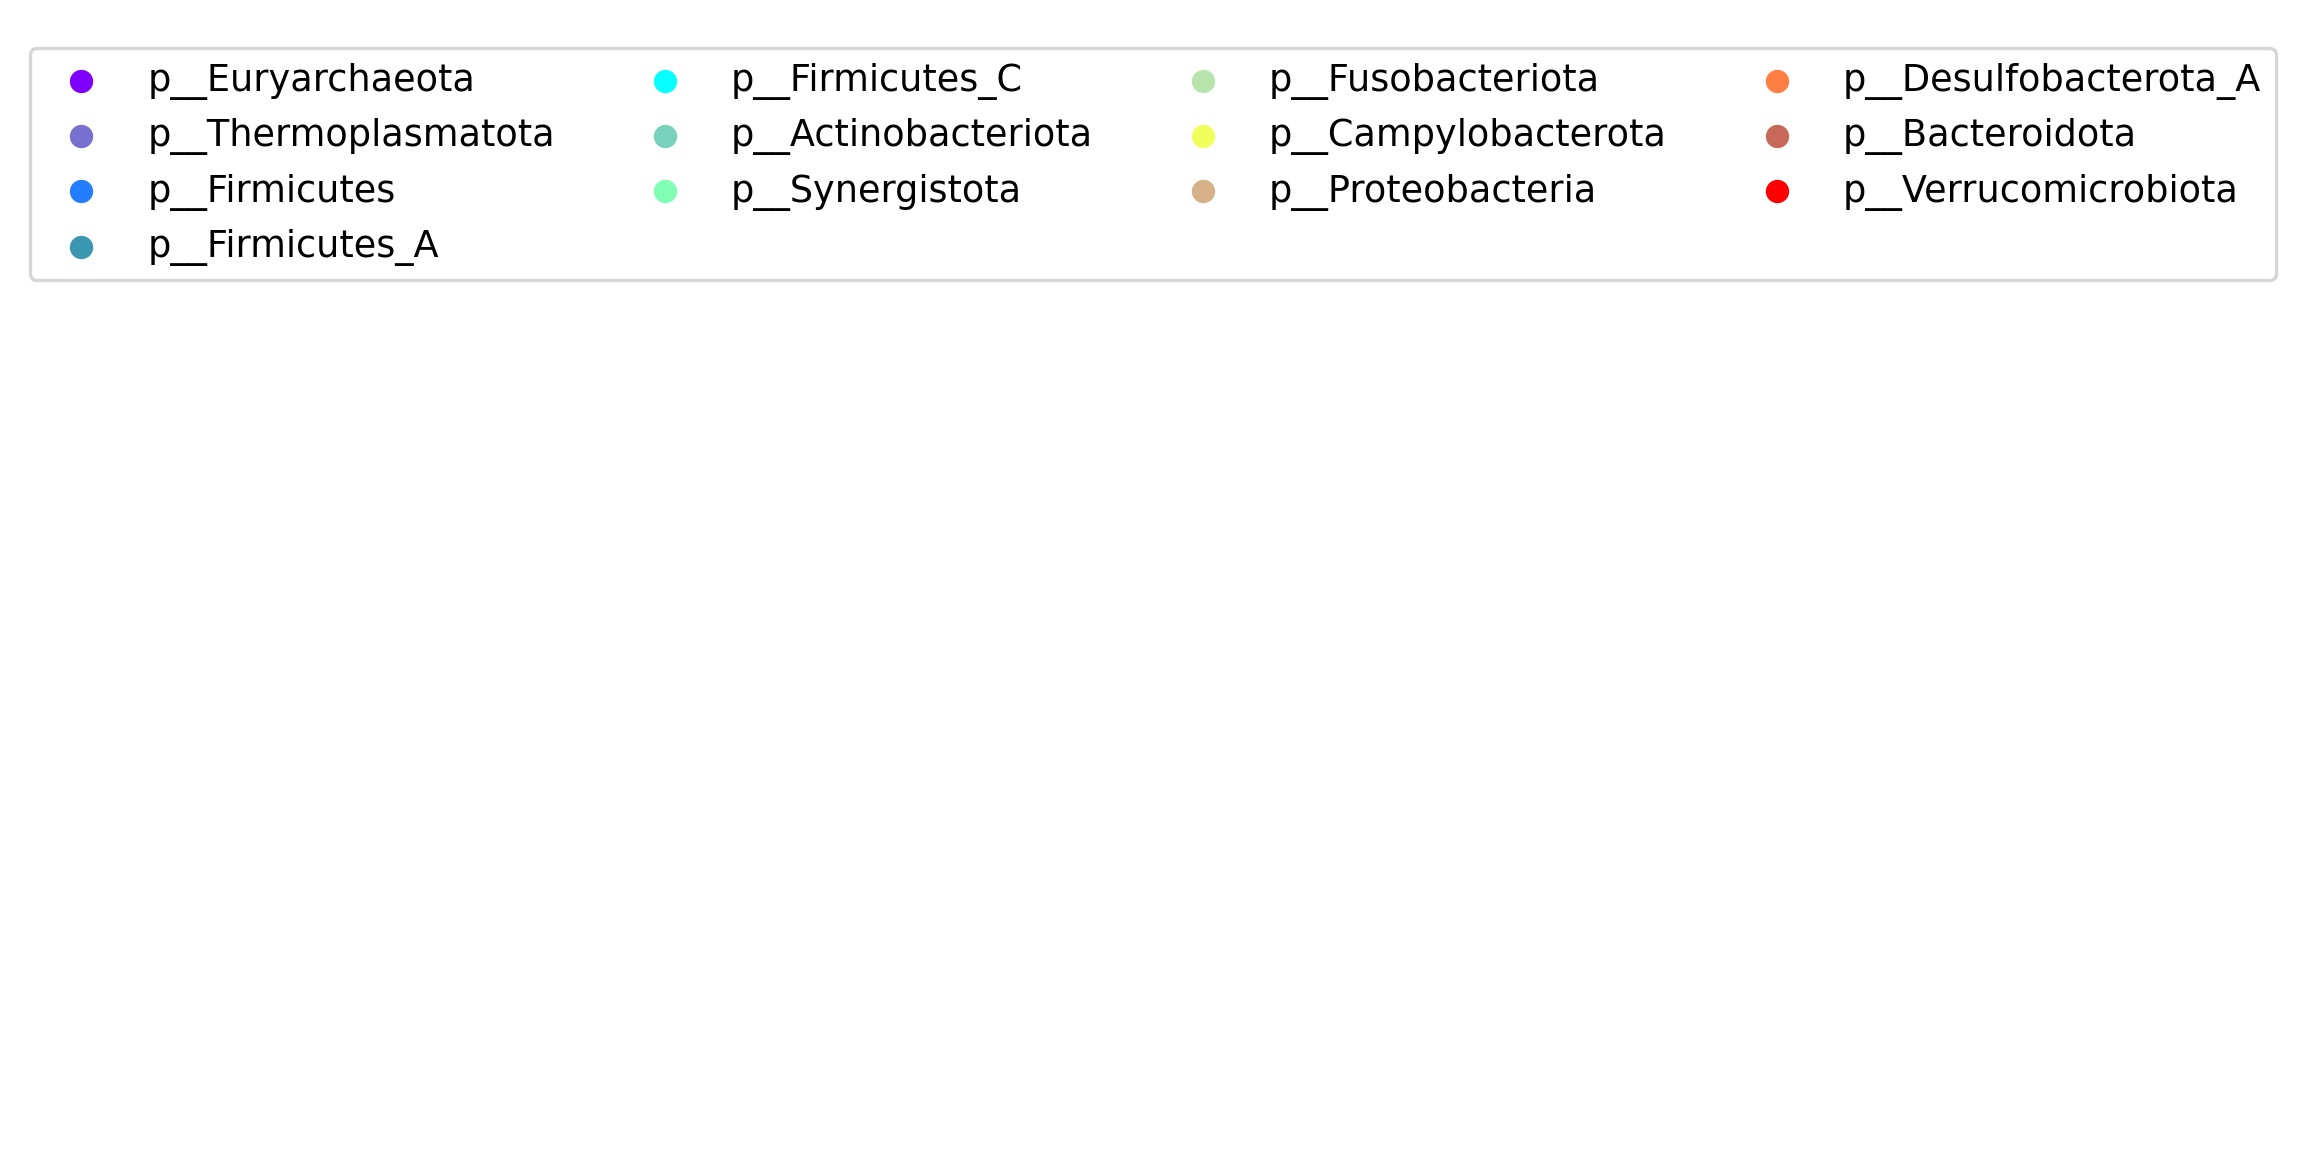

In [15]:
phylum_order = [
    "p__Euryarchaeota",
    "p__Thermoplasmatota",
    "p__Firmicutes",
    "p__Firmicutes_A",
    "p__Firmicutes_C",
    # "p__Firmicutes_B", # None in species_list1
    # "p__Firmicutes_G", # B/G/I not sure how related to C or A
    # "p__Firmicutes_I", #
    # "p__Cyanobacteria", # None in species_list1
    "p__Actinobacteriota",
    "p__Synergistota",
    "p__Fusobacteriota",
    "p__Campylobacterota",
    "p__Proteobacteria",
    "p__Desulfobacterota_A",
    "p__Bacteroidota",
    "p__Verrucomicrobiota",
    # "dummy0", # 18
    # "dummy1", # 19
    # "dummy2", # 20
]

phylum_palette = lib.plot.construct_ordered_palette(
    phylum_order,
    cm="rainbow",
    desaturate_levels=[1.0, 0.5],
)

for p__ in phylum_order:
    print(p__, phylum_palette[p__])
    plt.scatter([], [], color=phylum_palette[p__], label=p__)
plt.legend(ncols=4)
lib.plot.hide_axes_and_spines()

# assert len(set(phylum_palette.values())) == len((phylum_palette.values()))

## Prevalences

In [16]:
spgc_gene_prevalence = []
missing_species = []

_species_list = species_list3

for species in tqdm(_species_list):
    inpath = f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.uhgg-strain_gene.prevalence.tsv"
    if not os.path.exists(inpath):
        missing_species.append(species)
        continue
    data = pd.read_table(
        inpath, names=["gene_id", "prevalence"], index_col="gene_id"
    ).prevalence
    spgc_gene_prevalence.append(data)
spgc_gene_prevalence = pd.concat(spgc_gene_prevalence).sort_index()

print(
    len(missing_species),
    "out of",
    len(_species_list),
    "species are missing stats.",
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:03<00:00, 27.18it/s]


0 out of 99 species are missing stats.


In [17]:
ref_gene_prevalence = []
missing_species = []

_species_list = species_list3

for species in tqdm(_species_list):
    inpath = f"data/species/sp-{species}/midasdb.gene75_v20.uhgg-strain_gene.ref_prevalence.tsv"
    if not os.path.exists(inpath):
        missing_species.append(species)
        continue
    data = pd.read_table(
        inpath, names=["gene_id", "prevalence"], index_col="gene_id"
    ).prevalence
    ref_gene_prevalence.append(data)
ref_gene_prevalence = pd.concat(ref_gene_prevalence).sort_index()

print(
    len(missing_species),
    "out of",
    len(_species_list),
    "species are missing stats.",
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:04<00:00, 22.25it/s]


0 out of 99 species are missing stats.


### Figure 4A

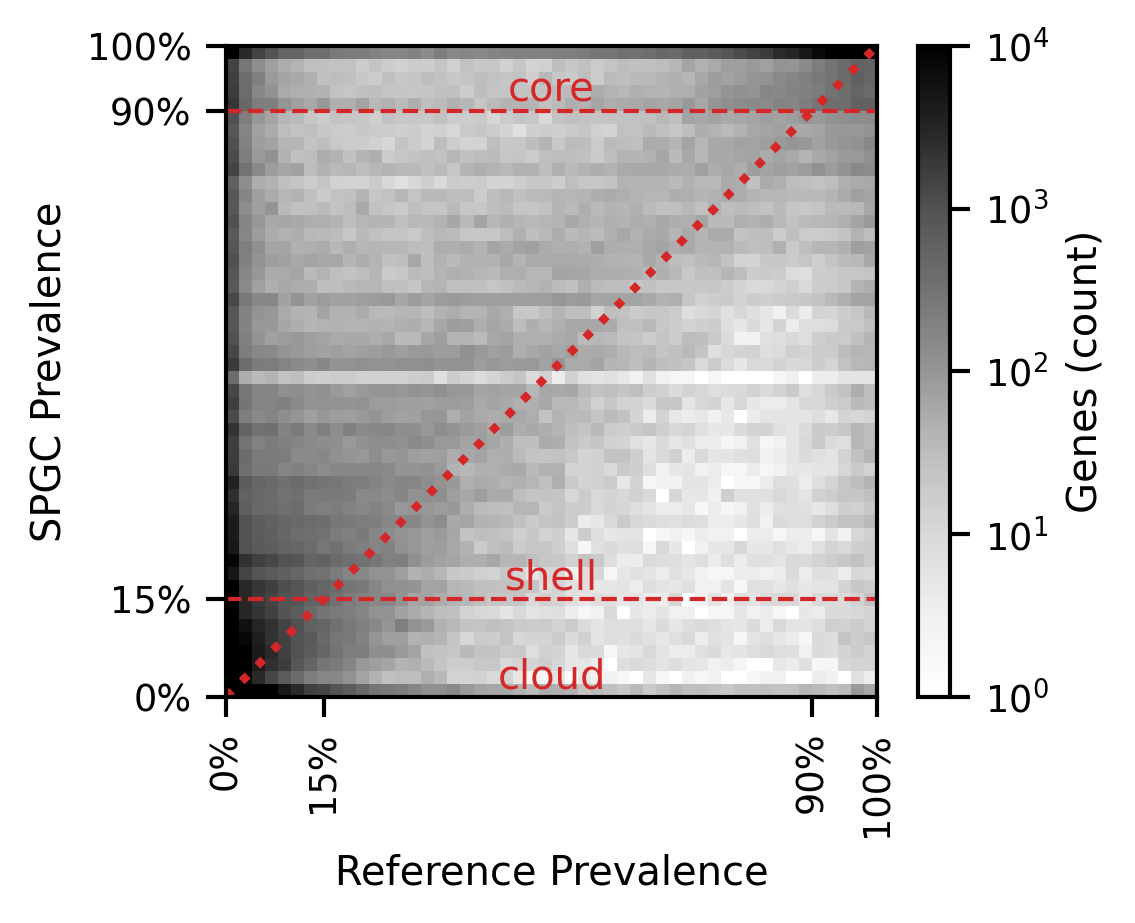

In [18]:
exclude_genes_never_greater_than = 0.01
d = pd.DataFrame(dict(ref=ref_gene_prevalence, spgc=spgc_gene_prevalence)).fillna(0)[
    lambda x: x.max(1) > exclude_genes_never_greater_than
]

fig, ax = plt.subplots(figsize=(3.5, 3))
bins = np.linspace(0, 1, num=51)
*_, art = ax.hist2d(
    "ref",
    "spgc",
    data=d,
    bins=bins,
    norm=mpl.colors.SymLogNorm(1, vmin=1, vmax=1e4),
    cmap="Grays",
)
fig.colorbar(art, ax=ax, label="Genes (count)", shrink=0.94)
ax.plot([0, 1], [0, 1], lw=2, linestyle=":", color="tab:red")


ax.set_aspect(1)
ax.set_xlabel("Reference Prevalence")
ax.set_ylabel("SPGC Prevalence")
ax.set_xticks([0, 0.15, 0.9, 1.0])
ax.set_yticks([0, 0.15, 0.9, 1.0])
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.annotate("core", xy=(0.5, 0.901), ha="center", va="bottom", color="tab:red")
ax.axhline(0.9, lw=1, linestyle="--", color="tab:red")
ax.annotate("shell", xy=(0.5, 0.151), ha="center", va="bottom", color="tab:red")
ax.axhline(0.15, lw=1, linestyle="--", color="tab:red")
ax.annotate("cloud", xy=(0.5, 0.0), ha="center", va="bottom", color="tab:red")
lib.plot.rotate_xticklabels(ax=ax, rotation=90, ha="center")
# lib.plot.rotate_yticklabels(ax=ax, rotation=45, va='top')

sp.stats.pearsonr(d.ref, d.spgc)

fig.savefig("fig/fig4a_gene_prevalence.pdf", bbox_inches="tight")

## Genome Fractions

### Distribution of genome fractions in inferred strains

In [19]:
# TODO: Gather genome fractions for strains
# Filter strains

spgc_prevalence_class_counts = []
missing_species = []

_species_list = species_list2

for species in tqdm(_species_list):
    inpath = f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.uhgg-strain_gene.prevalence_class_fraction.tsv"
    if not os.path.exists(inpath):
        missing_species.append(species)
        continue

    strain_list = filt_stats[
        lambda x: (x.species == species) & (x.passes_filter) & (x.genome_type == "SPGC")
    ].genome_id.unique()
    data = (
        pd.read_table(inpath, index_col="strain")
        .rename(index=str)
        .loc[strain_list]
        .assign(species=species)
        .reset_index()
        .set_index(["species", "strain"])
    )
    spgc_prevalence_class_counts.append(data)
spgc_prevalence_class_counts = pd.concat(spgc_prevalence_class_counts).sort_index()

print(
    len(missing_species),
    "out of",
    len(_species_list),
    "species are missing stats.",
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 443/443 [00:15<00:00, 28.34it/s]


0 out of 443 species are missing stats.


In [20]:
median_prevalence_class_fraction = (
    spgc_prevalence_class_counts.groupby("species")
    .median()
    .apply(lambda x: x / x.sum(), axis=1)
)
median_prevalence_class_fraction

,core,shell,cloud
species,,,
100003,0.582371,0.334882,0.082747
100013,0.835894,0.164106,0.000000
100016,0.849871,0.139983,0.010146
100018,0.896727,0.103273,0.000000
100022,0.576083,0.335055,0.088862
...,...,...,...
104600,1.000000,0.000000,0.000000
104637,1.000000,0.000000,0.000000
104639,0.910540,0.089460,0.000000


### Figure 4B

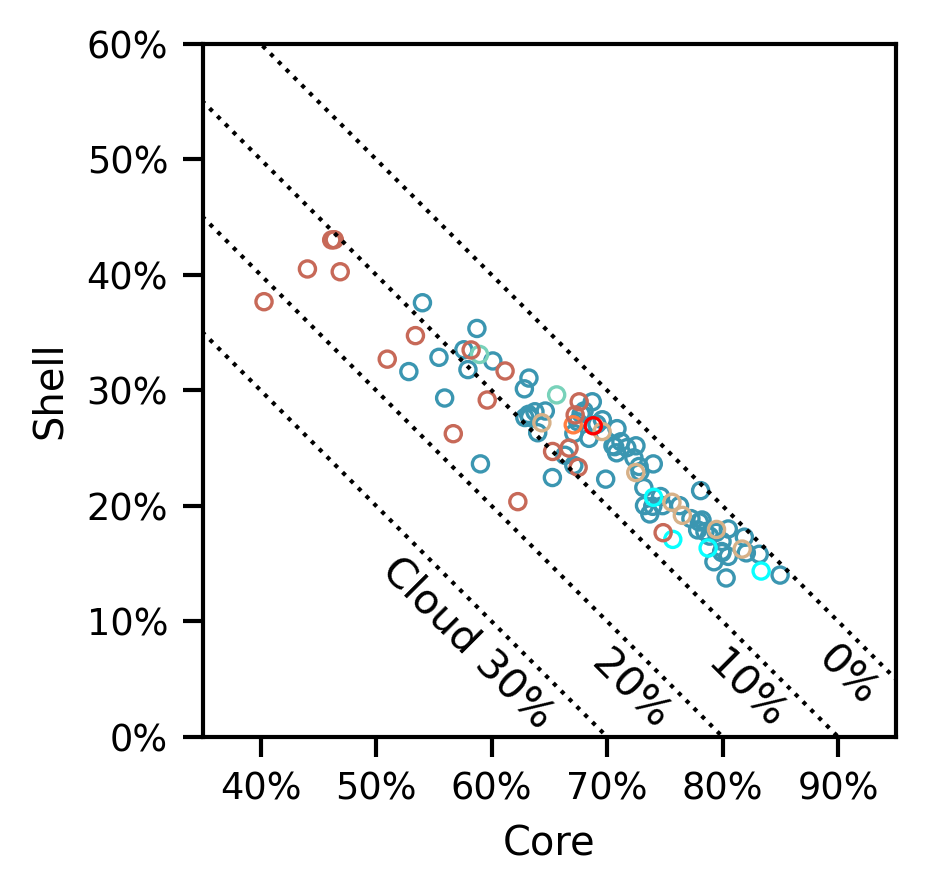

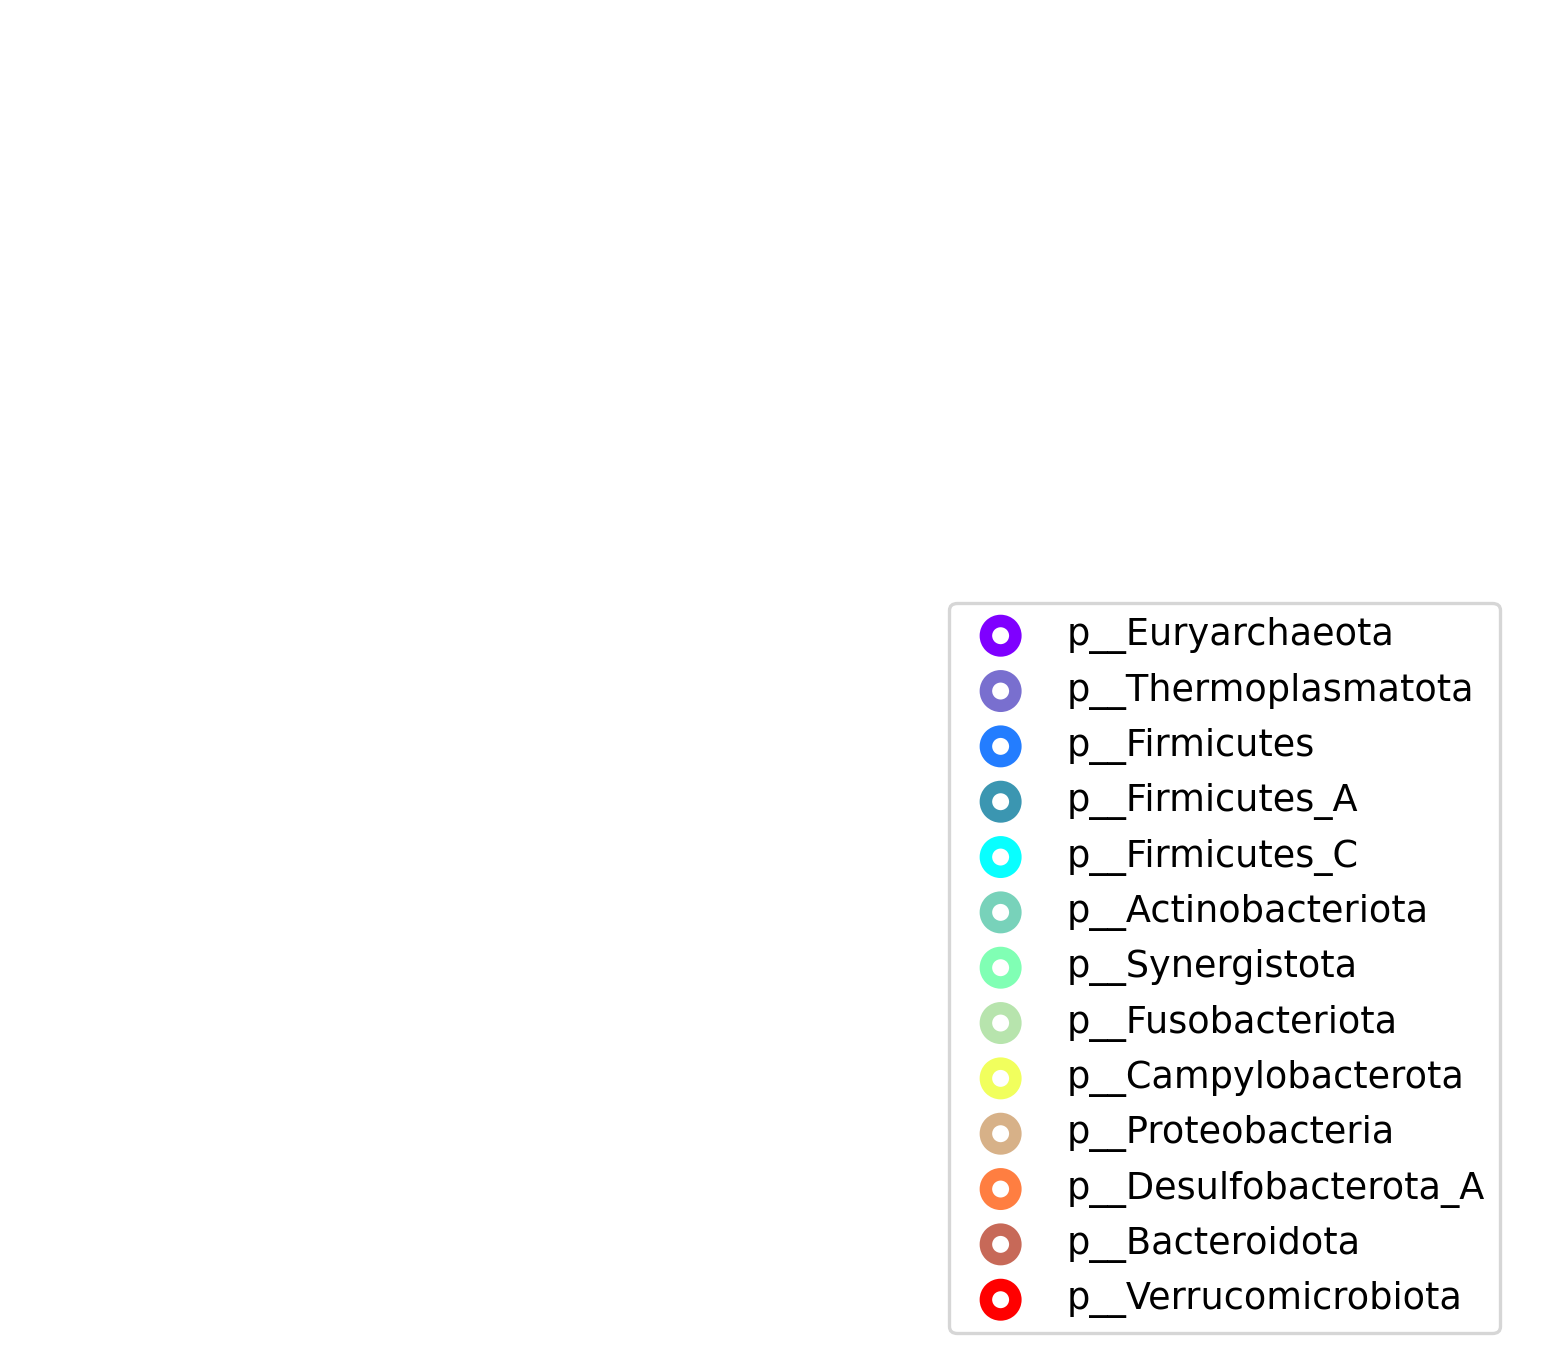

In [21]:
d0 = median_prevalence_class_fraction.loc[species_list3].assign(
    p__=lambda x: x.index.to_series().map(species_taxonomy.p__),
    num_genomes=spgc_prevalence_class_counts.reset_index()["species"].value_counts(),
)

fig, ax = plt.subplots(figsize=(3, 3))
_, ax_legend = plt.subplots()

for p__ in phylum_order:
    d1 = d0[lambda x: x.p__ == p__]
    ax.scatter(
        "core",
        "shell",
        data=d1,
        color=phylum_palette[p__],
        facecolor="none",
        s=15,
        label="__nolegend__",
        # marker="o",
        # lw=2,
        # facecolor="none",
        # alpha=0.85,
    )
    ax_legend.scatter(
        [], [], color=phylum_palette[p__], facecolor="none", label=p__, s=50, lw=3
    )
ax_legend.legend(bbox_to_anchor=(1, 0.5))
lib.plot.hide_axes_and_spines(ax_legend)


for cloud_frac, shift in [(0.0, 0.06), (0.1, 0.04), (0.2, 0.04), (0.3, 0.04)]:
    if cloud_frac == 0.3:
        annot = f"Cloud {cloud_frac:.0%}"
    else:
        annot = f"{cloud_frac:.0%}"
    ax.plot(
        [0, 1 - cloud_frac],
        [1 - cloud_frac, 0],
        lw=1,
        linestyle=":",
        color="k",
    )
    ax.annotate(
        annot,
        xy=(1 - cloud_frac - shift, -0.04 + shift),
        rotation=-45,
        va="bottom",
        ha="right",
        fontsize=10,
    )

ax.set_xlim(0.35, 0.95)
ax.set_ylim(0.0, 0.6)
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_xlabel("Core")
ax.set_ylabel("Shell")
ax.set_aspect(1)

fig.savefig("fig/fig4b_genome_fraction.pdf", bbox_inches="tight")

In [22]:
median_prevalence_class_fraction.loc[species_list3].quantile([0.25, 0.5, 0.75])

,core,shell,cloud
0.25,0.632223,0.192293,0.037653
0.50,0.695759,0.249930,0.052403
0.75,0.759886,0.282066,0.086697


### Distribution of genome fractions in reference strains

In [23]:
# TODO: Gather genome fractions for strains
# Filter strains

ref_prevalence_class_counts = []
missing_species = []

_species_list = species_list2

for species in tqdm(_species_list):
    inpath = f"data/species/sp-{species}/midasdb.gene75_v20.uhgg-strain_gene.prevalence_class_fraction.tsv"
    if not os.path.exists(inpath):
        missing_species.append(species)
        continue

    strain_list = filt_stats[
        lambda x: (x.species == species)
        & (x.passes_filter)
        & (x.genome_type.isin(["Isolate", "MAG"]))
    ].genome_id.unique()
    data = (
        pd.read_table(inpath, index_col="strain")
        .rename(index=str)
        .loc[strain_list]
        .assign(species=species)
        .reset_index()
        .set_index(["species", "strain"])
    )
    ref_prevalence_class_counts.append(data)
ref_prevalence_class_counts = pd.concat(ref_prevalence_class_counts).sort_index()

print(
    len(missing_species),
    "out of",
    len(_species_list),
    "species are missing stats.",
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 443/443 [00:23<00:00, 18.92it/s]


0 out of 443 species are missing stats.


In [24]:
ref_median_prevalence_class_fraction = (
    ref_prevalence_class_counts.groupby("species")
    .median()
    .apply(lambda x: x / x.sum(), axis=1)
)
ref_median_prevalence_class_fraction

,core,shell,cloud
species,,,
100003,0.690737,0.232072,0.077191
100013,0.527629,0.380793,0.091578
100016,0.724264,0.226432,0.049304
100018,0.790729,0.156675,0.052596
100022,0.645315,0.246162,0.108523
...,...,...,...
104600,0.742788,0.189904,0.067308
104637,0.819357,0.163280,0.017362
104639,0.848595,0.106981,0.044424


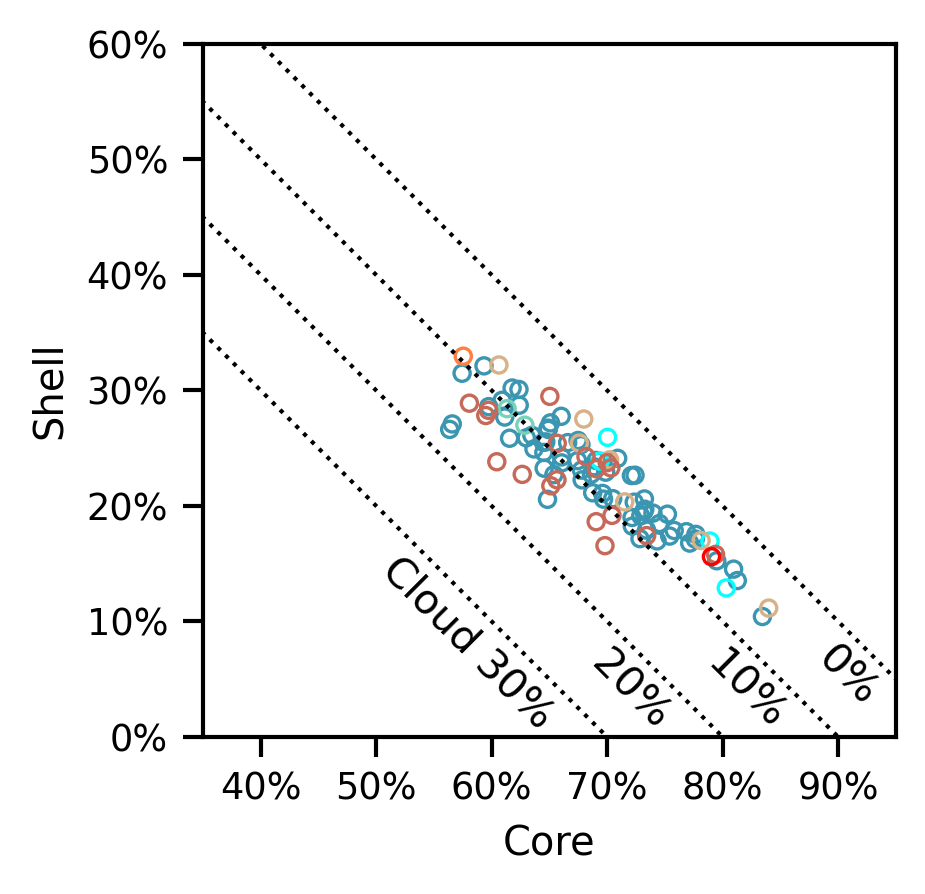

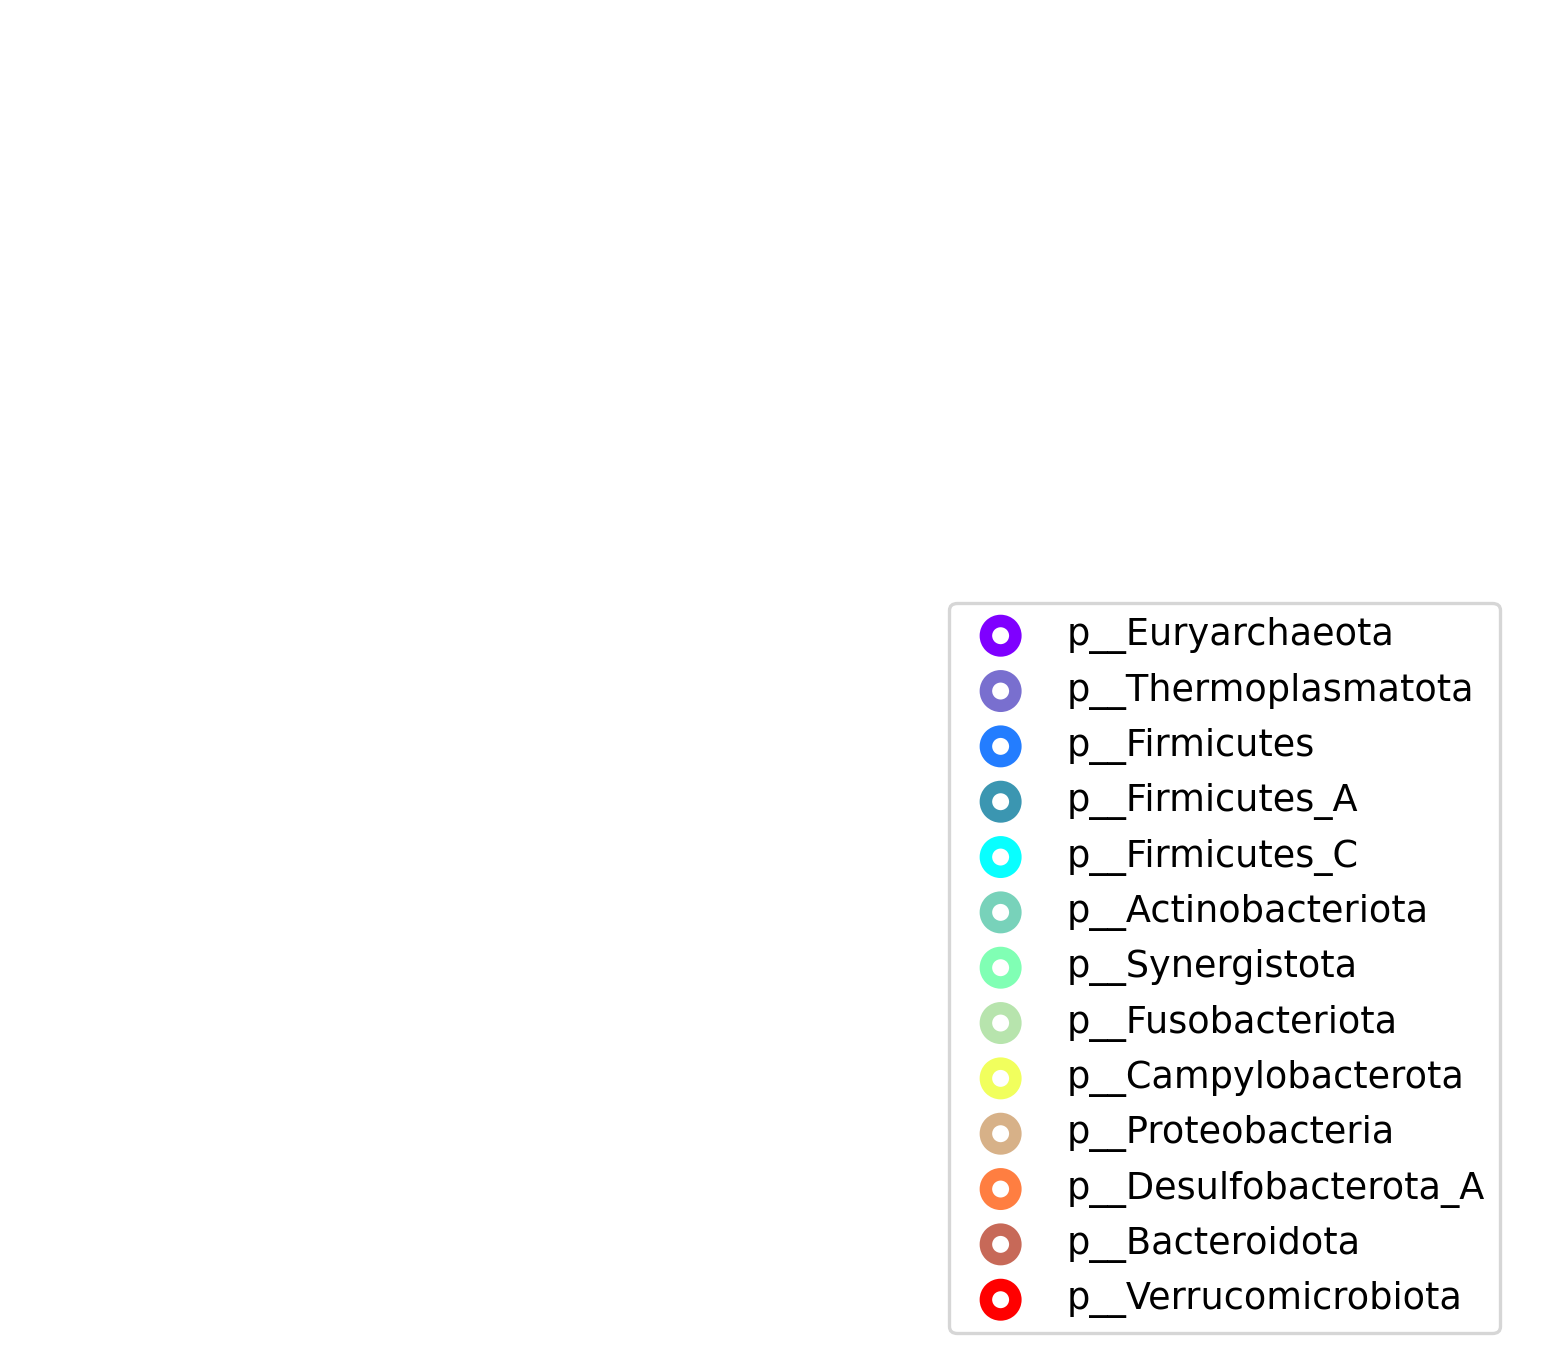

In [25]:
d0 = ref_median_prevalence_class_fraction.loc[species_list3].assign(
    p__=lambda x: x.index.to_series().map(species_taxonomy.p__),
    num_genomes=ref_prevalence_class_counts.reset_index()["species"].value_counts(),
)

fig, ax = plt.subplots(figsize=(3, 3))
_, ax_legend = plt.subplots()

for p__ in phylum_order:
    d1 = d0[lambda x: x.p__ == p__]
    ax.scatter(
        "core",
        "shell",
        data=d1,
        color=phylum_palette[p__],
        facecolor="none",
        s=15,
        label="__nolegend__",
        # marker="o",
        # lw=2,
        # facecolor="none",
        # alpha=0.85,
    )
    ax_legend.scatter(
        [], [], color=phylum_palette[p__], facecolor="none", label=p__, s=50, lw=3
    )
ax_legend.legend(bbox_to_anchor=(1, 0.5))
lib.plot.hide_axes_and_spines(ax_legend)


for cloud_frac, shift in [(0.0, 0.06), (0.1, 0.04), (0.2, 0.04), (0.3, 0.04)]:
    if cloud_frac == 0.3:
        annot = f"Cloud {cloud_frac:.0%}"
    else:
        annot = f"{cloud_frac:.0%}"
    ax.plot(
        [0, 1 - cloud_frac],
        [1 - cloud_frac, 0],
        lw=1,
        linestyle=":",
        color="k",
    )
    ax.annotate(
        annot,
        xy=(1 - cloud_frac - shift, -0.04 + shift),
        rotation=-45,
        va="bottom",
        ha="right",
        fontsize=10,
    )

ax.set_xlim(0.35, 0.95)
ax.set_ylim(0.0, 0.6)
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_xlabel("Core")
ax.set_ylabel("Shell")
ax.set_aspect(1)

fig.savefig("fig/fig_s2.pdf")

In [26]:
ref_median_prevalence_class_fraction.loc[species_list3].quantile([0.25, 0.5, 0.75])

,core,shell,cloud
0.25,0.645460,0.190566,0.063573
0.50,0.687611,0.232072,0.083854
0.75,0.730513,0.259032,0.101802


## COG Cateogry Enrichment

In [27]:
cog_category_description = pd.read_table(
    "ref/cog-20.categories.tsv",
    names=["cog_category", "color", "description"],
    index_col="cog_category",
).description
cog_category_description.sort_index()

cog_category
A                      RNA processing and modification
B                     Chromatin structure and dynamics
C                     Energy production and conversion
D    Cell cycle control, cell division, chromosome ...
E                  Amino acid transport and metabolism
F                  Nucleotide transport and metabolism
G                Carbohydrate transport and metabolism
H                    Coenzyme transport and metabolism
I                       Lipid transport and metabolism
J      Translation, ribosomal structure and biogenesis
K                                        Transcription
L                Replication, recombination and repair
M               Cell wall/membrane/envelope biogenesis
N                                        Cell motility
O    Posttranslational modification, protein turnov...
P               Inorganic ion transport and metabolism
Q    Secondary metabolites biosynthesis, transport ...
R                     General function prediction on

In [28]:
cog_category = []
for species in tqdm(species_list3):
    cog_category_inpath = (
        f"data/species/sp-{species}/midasdb_v20.emapper.gene75_x_cog_category.tsv"
    )
    cog_category.append(pd.read_table(cog_category_inpath))

cog_category = pd.concat(cog_category)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:02<00:00, 36.57it/s]


In [29]:
gene_x_cog_category_matrix = (
    cog_category.set_index(["centroid_75", "cog_category"])
    .assign(annotation=True)
    .unstack("cog_category", fill_value=False)
    .annotation
    # .reindex(spgc_gene_prevalence.index)
    # .fillna({'no_category': True})
    # .fillna(False)
)
gene_x_cog_category_matrix.sum()

cog_category
A                 670
B                 351
C              158197
D              103677
E              207924
F               88709
G              298813
H              155169
I               92309
J              166983
K              424962
L              477184
M              351710
N               59721
O              135997
P              163148
Q               44941
R              307454
T              218346
U              103252
V              227007
W               13321
X              214879
Y                   2
Z                2790
no_category    997632
dtype: int64

In [30]:
# Double check that only genes with no other cog category get assigned "no_category".
assert not idxwhere(gene_x_cog_category_matrix[lambda x: x.no_category].sum(1) > 1)

In [31]:
spgc_prevalence_class = spgc_gene_prevalence.map(
    lambda x: np.where(
        x > 0.9, "core", np.where(x > 0.15, "shell", np.where(x > 0, "cloud", "absent"))
    )
)

In [32]:
d0 = (
    spgc_prevalence_class.to_frame("prevalence_class")
    .join(gene_x_cog_category_matrix)
    .assign(
        cloud=lambda x: x.prevalence_class == "cloud",
        shell=lambda x: x.prevalence_class == "shell",
        core=lambda x: x.prevalence_class == "core",
        absent=lambda x: x.prevalence_class == "absent",
    )
)[lambda x: ~x.absent]

result = []
for _prevalence_class, _cog_category in tqdm(
    list(
        product(
            ["core", "shell", "cloud", "absent"], gene_x_cog_category_matrix.columns
        )
    )
):
    d1 = (
        d0[[_prevalence_class, _cog_category]]
        .value_counts()
        .unstack()
        .reindex(index=[True, False], columns=[True, False])
        .fillna(0)
    )
    d1_pc = d1 + 1
    log_oddsratio = np.log2(
        (d1_pc.loc[True, True] / d1_pc.loc[True, False])
        / (d1_pc.loc[False, True] / d1_pc.loc[False, False])
    )
    result.append(
        (
            _prevalence_class,
            _cog_category,
            d1.loc[True, True],
            log_oddsratio,
            sp.stats.fisher_exact(d1)[1],
        )
    )
prevalence_class_cog_category_enrichment = pd.DataFrame(
    result,
    columns=[
        "prevalence_class",
        "cog_category",
        "num_genes",
        "log2_oddsratio",
        "pvalue",
    ],
).set_index(["prevalence_class", "cog_category"])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:09<00:00, 10.91it/s]


In [33]:
cog_category_label = {
    "J": "Ribosomes / Translation - J",
    "A": "RNA Processing - A",
    "K": "Transcription - K",
    "L": "DNA replication/recombination/repair - L",
    "B": "Chromatin - B",
    "D": "Cell cycle control - D",
    "Y": "Nucleus - Y",
    "V": "Defense - V",
    "T": "Signal transduction - T",
    "M": "Cell envelope - M",
    "N": "Motility - N",
    "Z": "Cytoskeleton - Z",
    "W": "Extracellular structures - W",
    "U": "Secretion / vesicular transport - U",
    "O": "Protein processing - O",
    "X": '"Mobilome" - X',
    "C": "Energy - C",
    "G": "Carbohydrates - G",
    "E": "Amino acids - E",
    "F": "Nucleotides - F",
    "H": "Coenzymes - H",
    "I": "Lipids - I",
    "P": "Inorganic ions - P",
    "Q": "Secondary metabolites - Q",
    "R": "General only - R",
    "S": "TODO: This shouldn't show up",
    "no_category": "Unknown",
}

In [34]:
prevalence_class_cog_category_enrichment.groupby(
    "cog_category"
).num_genes.sum().sort_values()

cog_category
Y                   0.0
B                  73.0
A                 172.0
Z                 719.0
W                2537.0
Q                9444.0
N               12889.0
D               21731.0
F               21818.0
I               21938.0
U               22027.0
O               30083.0
H               36440.0
C               37775.0
X               39176.0
V               40316.0
P               40622.0
J               42042.0
T               46840.0
E               50799.0
R               66169.0
G               69362.0
M               75724.0
K               79817.0
L               86040.0
no_category    194996.0
Name: num_genes, dtype: float64

In [35]:
prevalence_class_cog_category_enrichment.num_genes.unstack("prevalence_class").loc[
    ["Y", "B", "A"]
].sum(
    1
)  # .sum()

cog_category
Y      0.0
B     73.0
A    172.0
dtype: float64

### Figure 4C

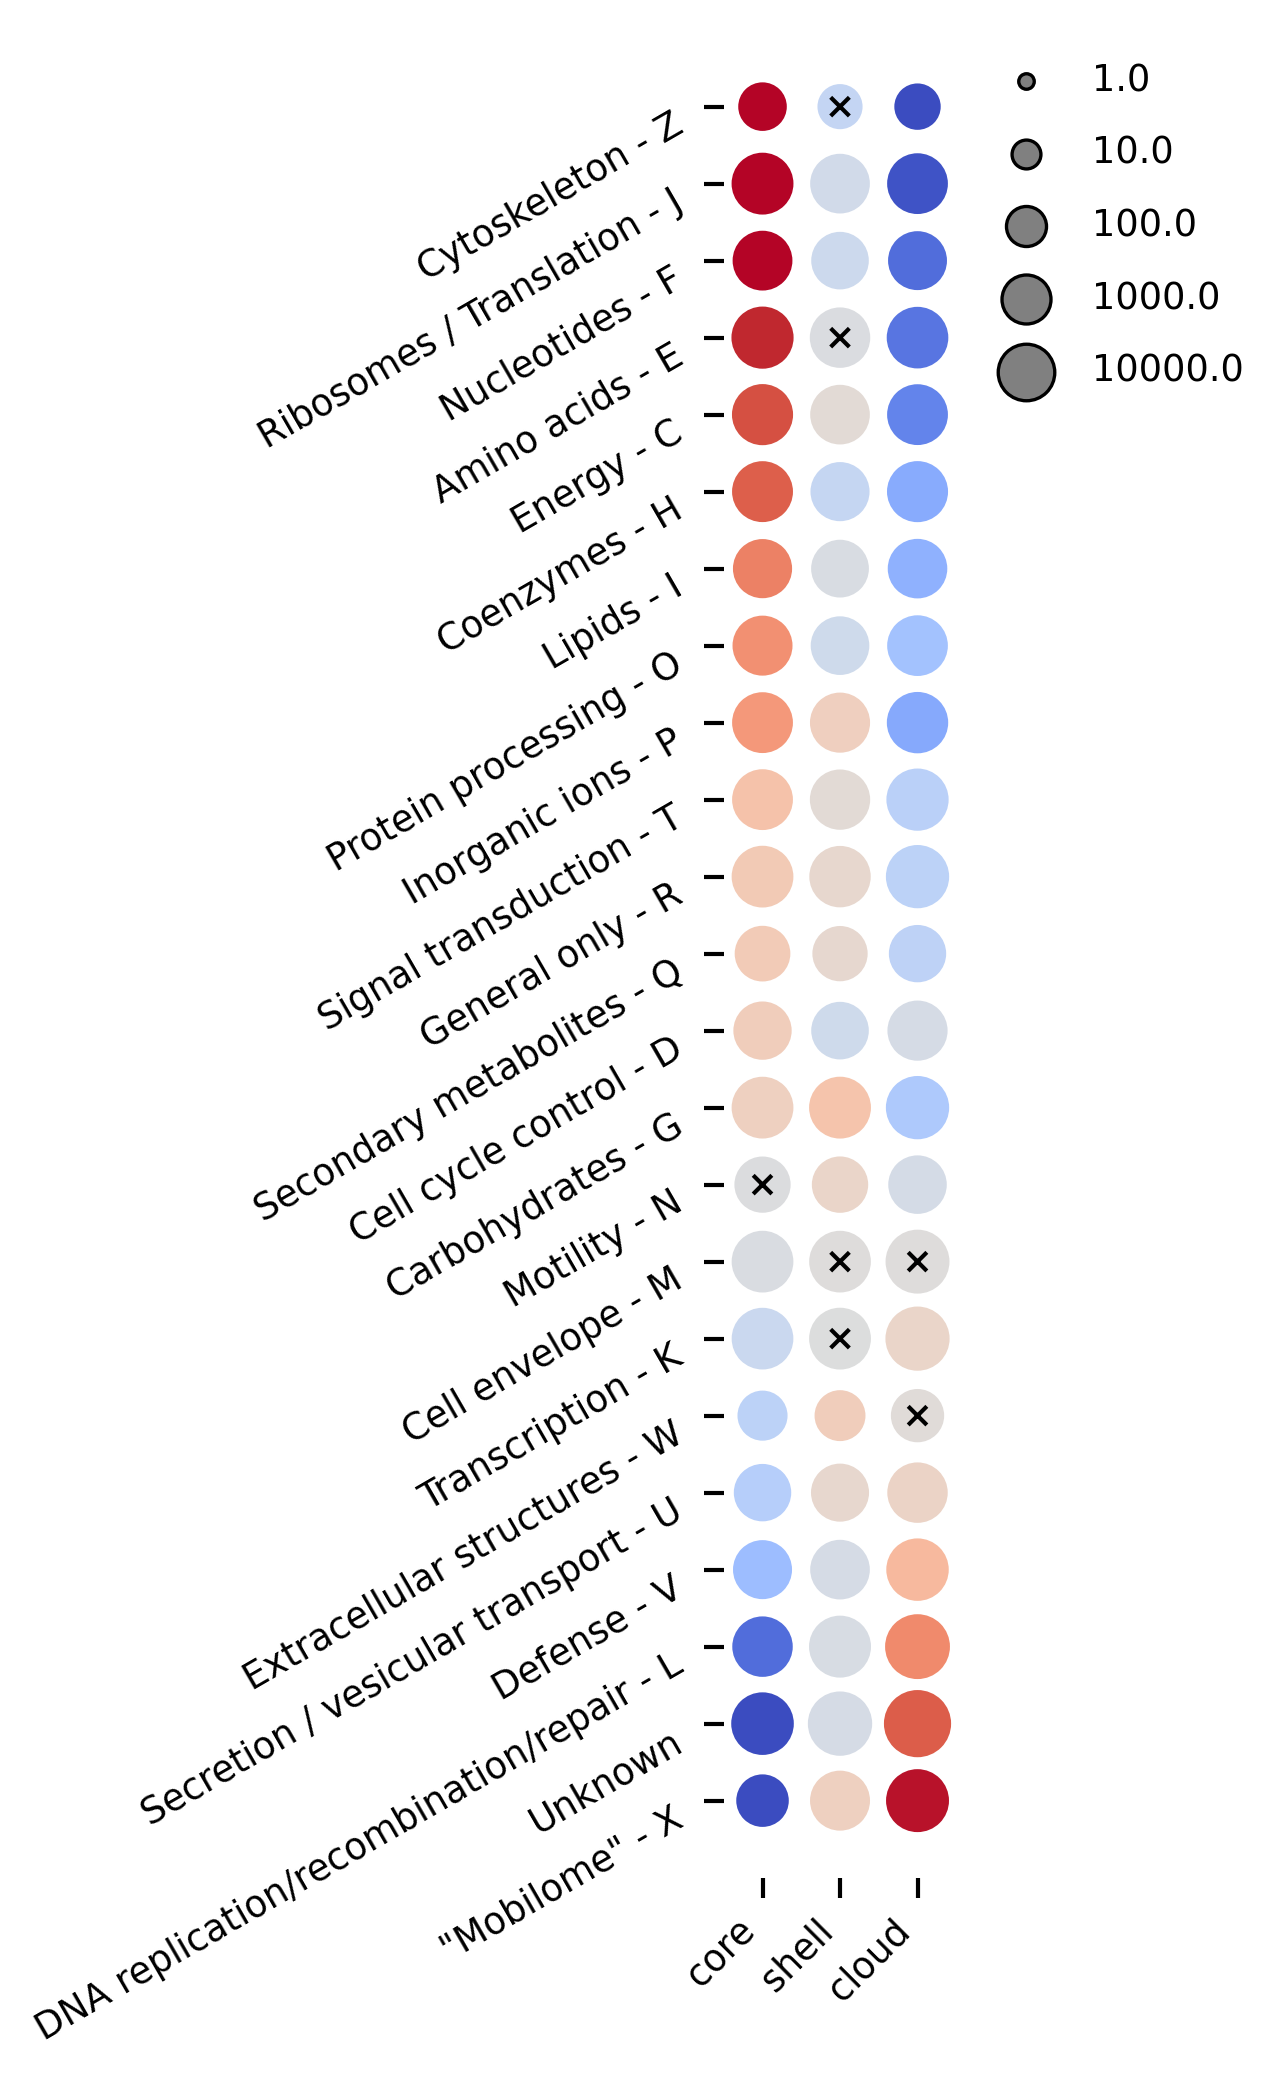

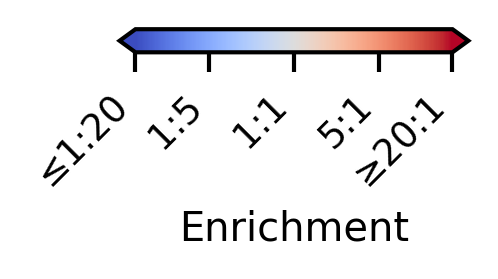

In [36]:
d = prevalence_class_cog_category_enrichment

cog_category_drop_list = ["Y", "B", "A"]

cog_category_order = [
    c
    for c in d.xs("core").log2_oddsratio.sort_values(ascending=True).index
    if c not in cog_category_drop_list
]
cog_category_idx = pd.Series(
    np.arange(len(cog_category_order)), index=cog_category_order
).rename_axis("cog_category")
prevalence_class_order = ["core", "shell", "cloud"]
prevalence_class_idx = pd.Series(
    np.arange(len(prevalence_class_order)), index=prevalence_class_order
).rename_axis("prevalence_class")

num_genes_to_size = lambda x: 20 * np.log(x + 1)
signif_size = 20

d = (
    d.join(prevalence_class_idx.rename("prevalence_class_idx"))
    .join(cog_category_idx.rename("cog_category_idx"))
    .assign(
        num_genes_s=lambda x: num_genes_to_size(x.num_genes),
        signif=lambda x: signif_size * (x.pvalue >= 0.05),
    )
)

vmin, vmax = -np.log10(20), np.log10(20)

cmap = "coolwarm"
norm = mpl.colors.PowerNorm(1, vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(1, 8), facecolor="none")
ax.scatter(
    x="prevalence_class_idx",
    y="cog_category_idx",
    data=d,
    c="log2_oddsratio",
    s="num_genes_s",
    cmap=cmap,
    norm=norm,
    label="__nolegend__",
)
ax.scatter(
    x="prevalence_class_idx",
    y="cog_category_idx",
    data=d,
    s="signif",
    color="k",
    marker="x",
    label="__nolegend__",
    lw=1,
)
# for _, d1 in d.iterrows():
#     ax.annotate(d1.signif, xy=(d1.prevalence_class_idx, d1.cog_category_idx), ha='center', va='center')


ax.set_xlim(-0.5, len(prevalence_class_order) - 0.5)
ax.set_ylim(-1.0, len(cog_category_order))
ax.set_xticks(prevalence_class_idx)
ax.set_xticklabels(prevalence_class_order)
ax.set_yticks(cog_category_idx)
ax.set_yticklabels([cog_category_label[c] for c in cog_category_order])
lib.plot.rotate_yticklabels(ax=ax, rotation=30, va="top")
lib.plot.rotate_xticklabels(ax=ax)
# lib.plot.rotate_yticklabels(ax=ax, rotation=0, va='top')


# Remove frame
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

for num_genes in np.logspace(0, 4, num=5):
    ax.scatter(
        [],
        [],
        color="grey",
        edgecolor="black",
        label=num_genes,
        s=num_genes_to_size(num_genes),
    )
ax.legend(
    bbox_to_anchor=(1, 1),
    frameon=False,
    labelspacing=1,
)
fig.savefig("fig/fig4c_cogcat_enrichment.pdf", bbox_inches="tight")

fig, ax = plt.subplots(figsize=(1.5, 0.1))
fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax,
    extend="both",
    label="Enrichment",
    orientation="horizontal",
)
ax.set_xticks([-np.log10(20), -np.log10(5), 0, np.log10(5), np.log10(20)])
ax.set_xticklabels(["≤1:20", "1:5", "1:1", "5:1", "≥20:1"])
lib.plot.rotate_xticklabels(ax=ax)

fig.savefig("fig/fig4c_cogcat_enrichment_cbar.pdf", bbox_inches="tight")

In [37]:
d = prevalence_class_cog_category_enrichment

cog_category_order = d.xs("core").log2_oddsratio.sort_values(ascending=True).index
cog_category_idx = pd.Series(
    np.arange(len(cog_category_order)), index=cog_category_order
).rename_axis("cog_category")
prevalence_class_order = ["core", "shell", "cloud"]
prevalence_class_idx = pd.Series(
    np.arange(len(prevalence_class_order)), index=prevalence_class_order
).rename_axis("prevalence_class")

num_genes_to_size = lambda x: 55 * np.log(x + 1)
signif_size = 20

d = (
    d.join(prevalence_class_idx.rename("prevalence_class_idx"))
    .join(cog_category_idx.rename("cog_category_idx"))
    .assign(
        num_genes_s=lambda x: num_genes_to_size(x.num_genes),
        signif=lambda x: signif_size * (x.pvalue >= 0.05),
    )
)

d.xs("core").sort_values("log2_oddsratio", ascending=False).join(
    cog_category_description
)

,num_genes,log2_oddsratio,pvalue,prevalence_class_idx,cog_category_idx,num_genes_s,signif,description
cog_category,,,,,,,,
Z,361.0,1.620109,9.875781e-49,0.0,25,324.040432,0,Cytoskeleton
Y,0.0,1.606381,1.000000e+00,0.0,24,0.000000,20,Nuclear structure
J,19295.0,1.458386,0.000000e+00,0.0,23,542.720920,0,"Translation, ribosomal structure and biogenesis"
F,9731.0,1.335741,0.000000e+00,0.0,22,505.074609,0,Nucleotide transport and metabolism
E,21180.0,1.210159,0.000000e+00,0.0,21,547.847291,0,Amino acid transport and metabolism
C,14959.0,1.053213,0.000000e+00,0.0,20,528.722439,0,Energy production and conversion
H,14030.0,0.980534,0.000000e+00,0.0,19,525.196345,0,Coenzyme transport and metabolism
I,7883.0,0.796009,3.781125e-307,0.0,18,493.492487,0,Lipid transport and metabolism
O,10347.0,0.703318,9.031026e-320,0.0,17,508.450170,0,"Posttranslational modification, protein turnov..."


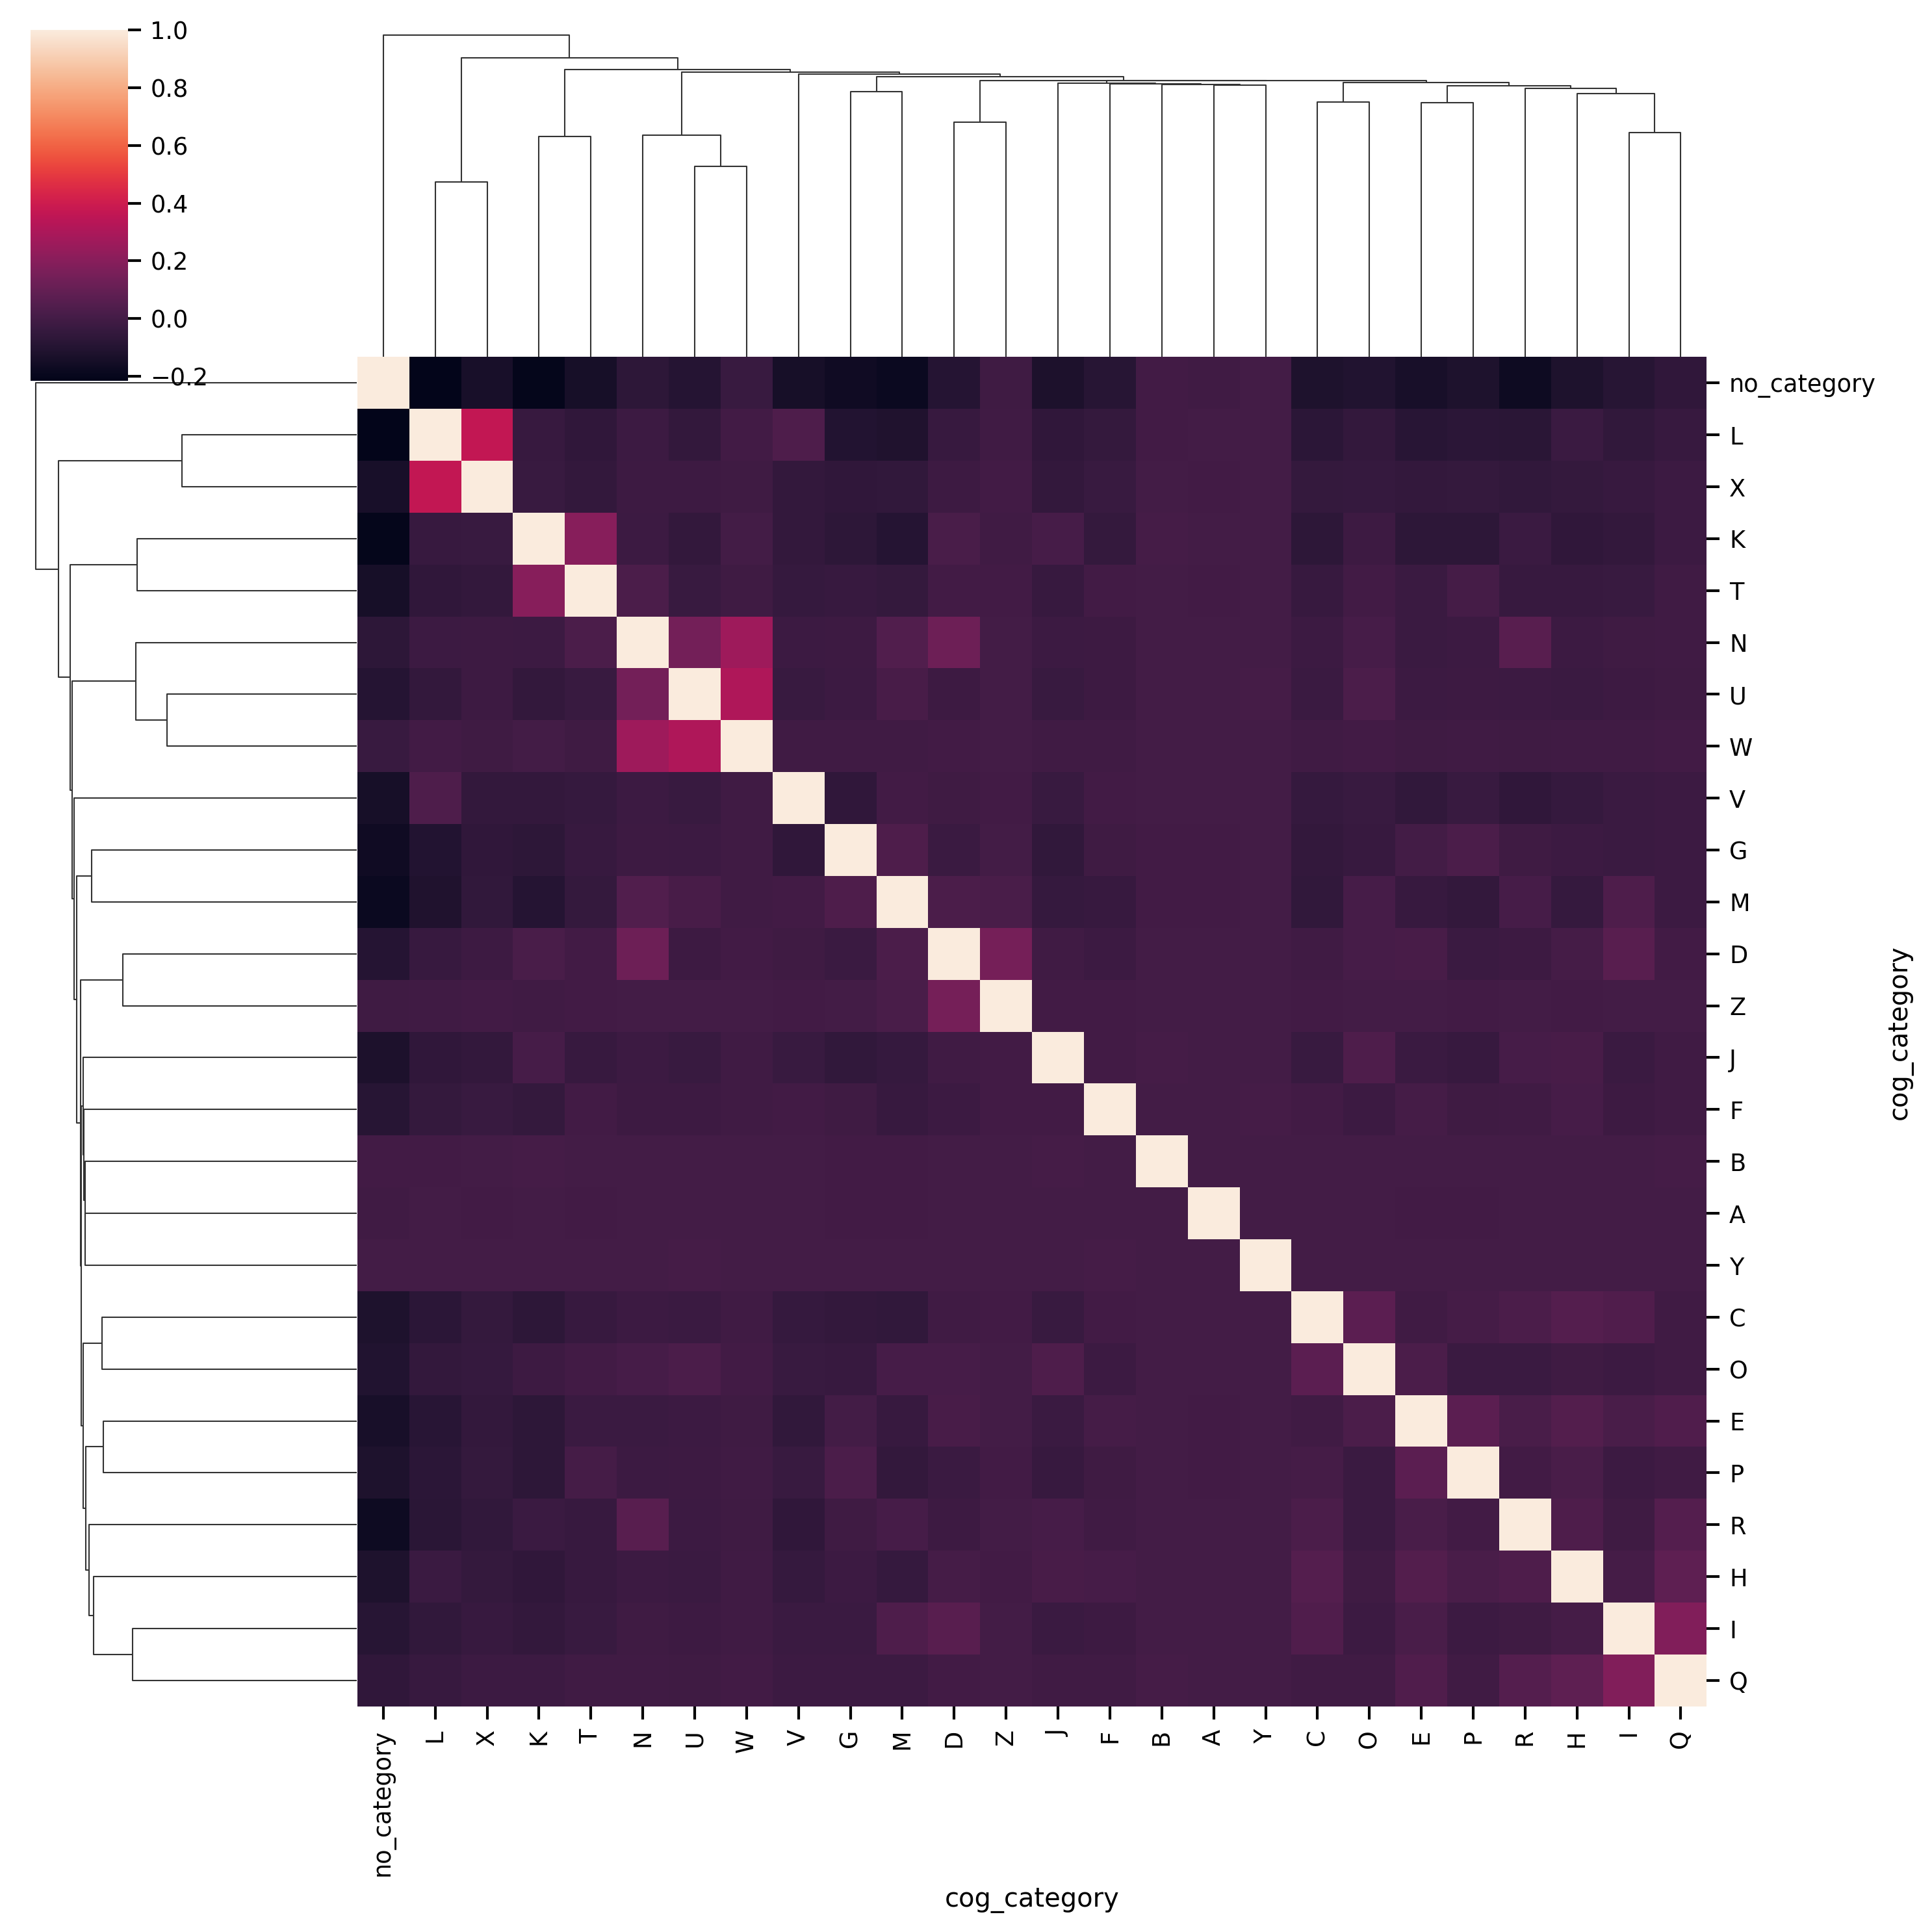

In [38]:
sns.clustermap(1 - dmatrix(gene_x_cog_category_matrix.T, metric="correlation"))

## AMR Genes Analysis

In [39]:
amr_gene = []
missing = []

for species in tqdm(species_list):
    amr_gene_inpath = f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.amr-strain_gene.tsv"
    if os.path.exists(amr_gene_inpath):
        amr_gene.append(
            pd.read_table(amr_gene_inpath, index_col="gene_id").rename(
                columns=lambda x: species + "_" + x
            )
        )
        assert amr_gene[-1].index.is_unique
    else:
        missing.append(species)

amr_gene = pd.concat(amr_gene, axis=1).fillna(0) > 0
print(len(missing))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 627/627 [00:03<00:00, 186.48it/s]


11


0.13728282540586728


(array([8.62717175e-01, 7.00655084e-02, 1.96525206e-02, 1.19624039e-02,
        1.59498718e-02, 1.11079465e-02, 5.98120194e-03, 1.42409570e-03,
        5.69638280e-04, 5.69638280e-04]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

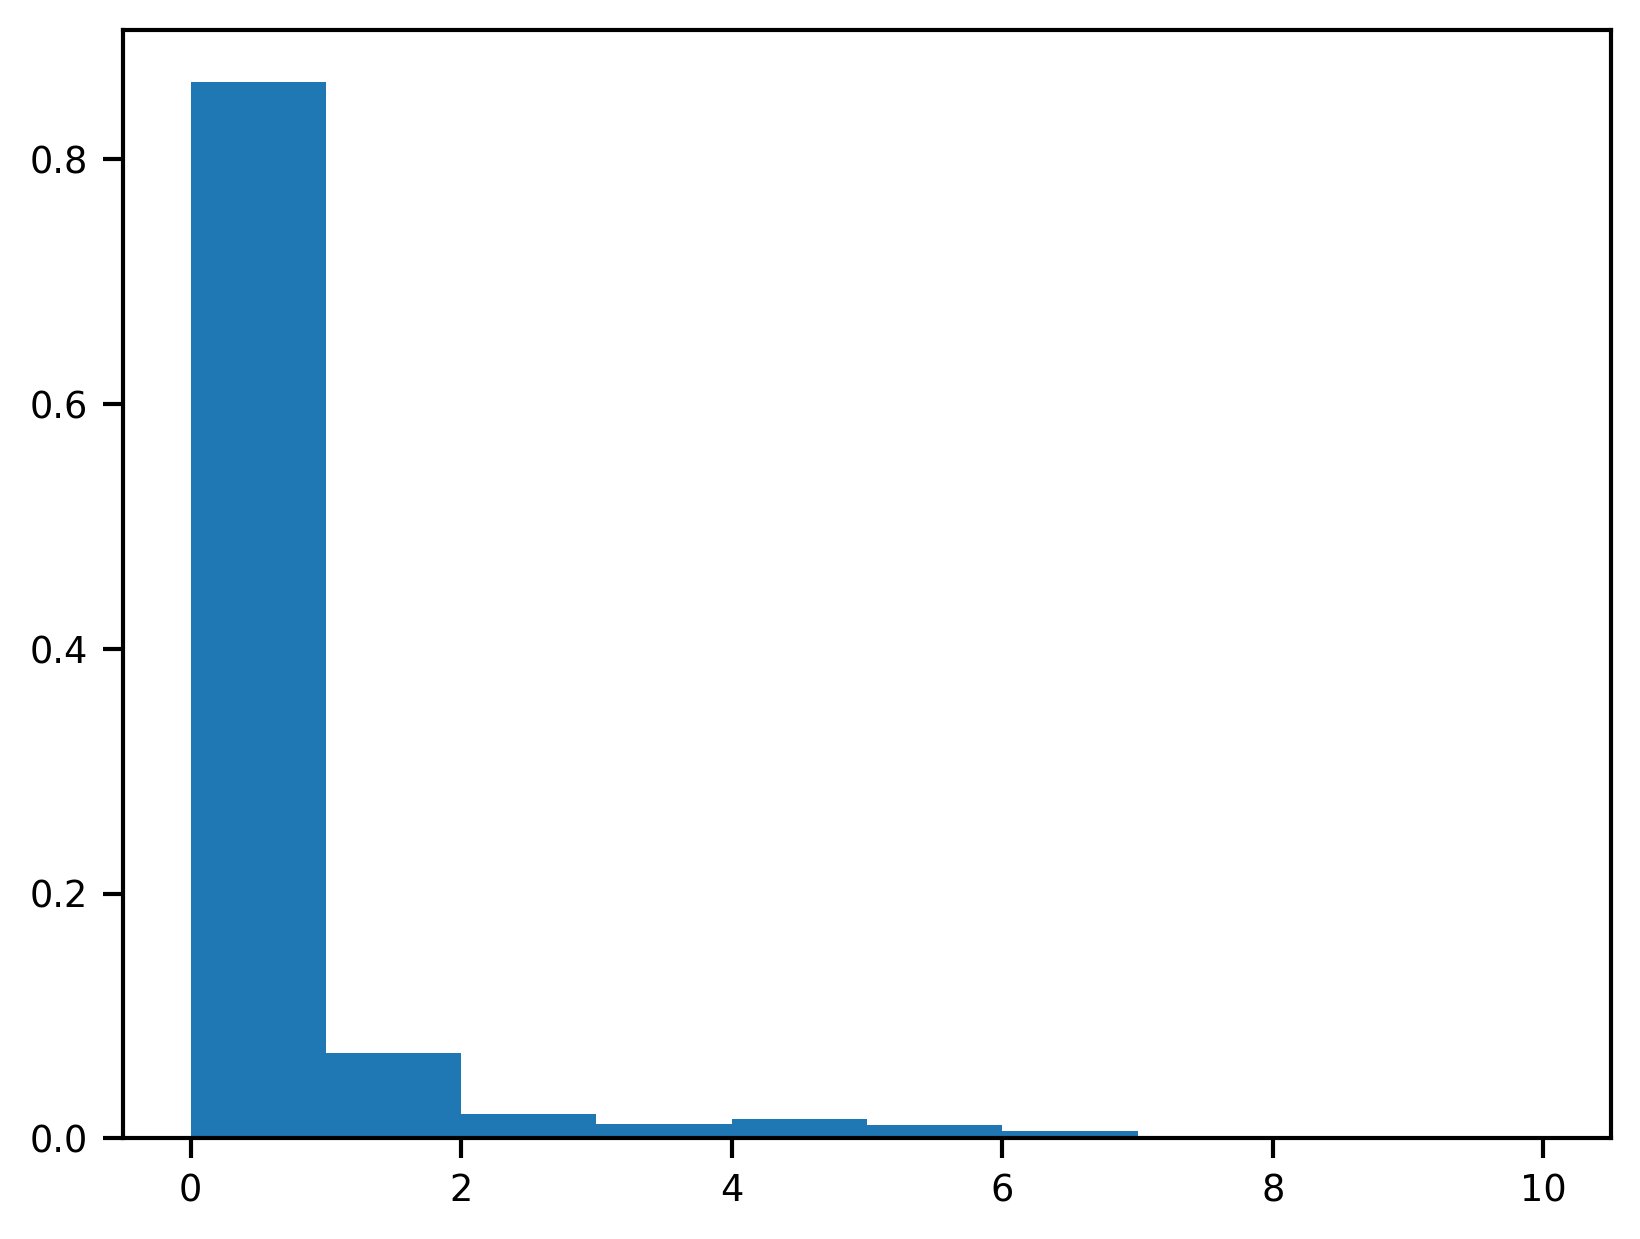

In [40]:
_strain_list = spgc_strain_list2

d0 = (
    amr_gene.reindex(columns=_strain_list)
    .dropna(axis=1)
    .sum()
    .rename_axis(index="species_strain")
    .reset_index(name="num_amr_accessions")
    .assign(
        species=lambda x: x.species_strain.str.split("_").str[0],
        strain=lambda x: x.species_strain.str.split("_").str[1],
    )
    .join(species_taxonomy, on="species")
)

print((d0.num_amr_accessions > 0).mean())
plt.hist(d0.num_amr_accessions, density=True)

In [41]:
print((d0.num_amr_accessions > 0).sum(), (d0.num_amr_accessions >= 0).sum())

482 3511


In [42]:
d0.assign(has_amr=lambda x: x.num_amr_accessions > 0).groupby('p__').has_amr.agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)

,sum,count,mean
p__,,,
p__Bacteroidota,271,727,0.372765
p__Fusobacteriota,1,4,0.250000
p__Proteobacteria,41,189,0.216931
p__Firmicutes,7,80,0.087500
p__Firmicutes_A,151,2232,0.067652
p__Actinobacteriota,4,64,0.062500
p__Firmicutes_C,6,141,0.042553
p__Verrucomicrobiota,1,41,0.024390
p__Desulfobacterota_A,0,24,0.000000


(array([355.,  13.,  18.,   8.,   2.,   2.,   8.,   1.,   1.,   0.,   6.,
          1.,   0.,   2.,   0.,   1.,   2.,   2.,   1.,  20.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

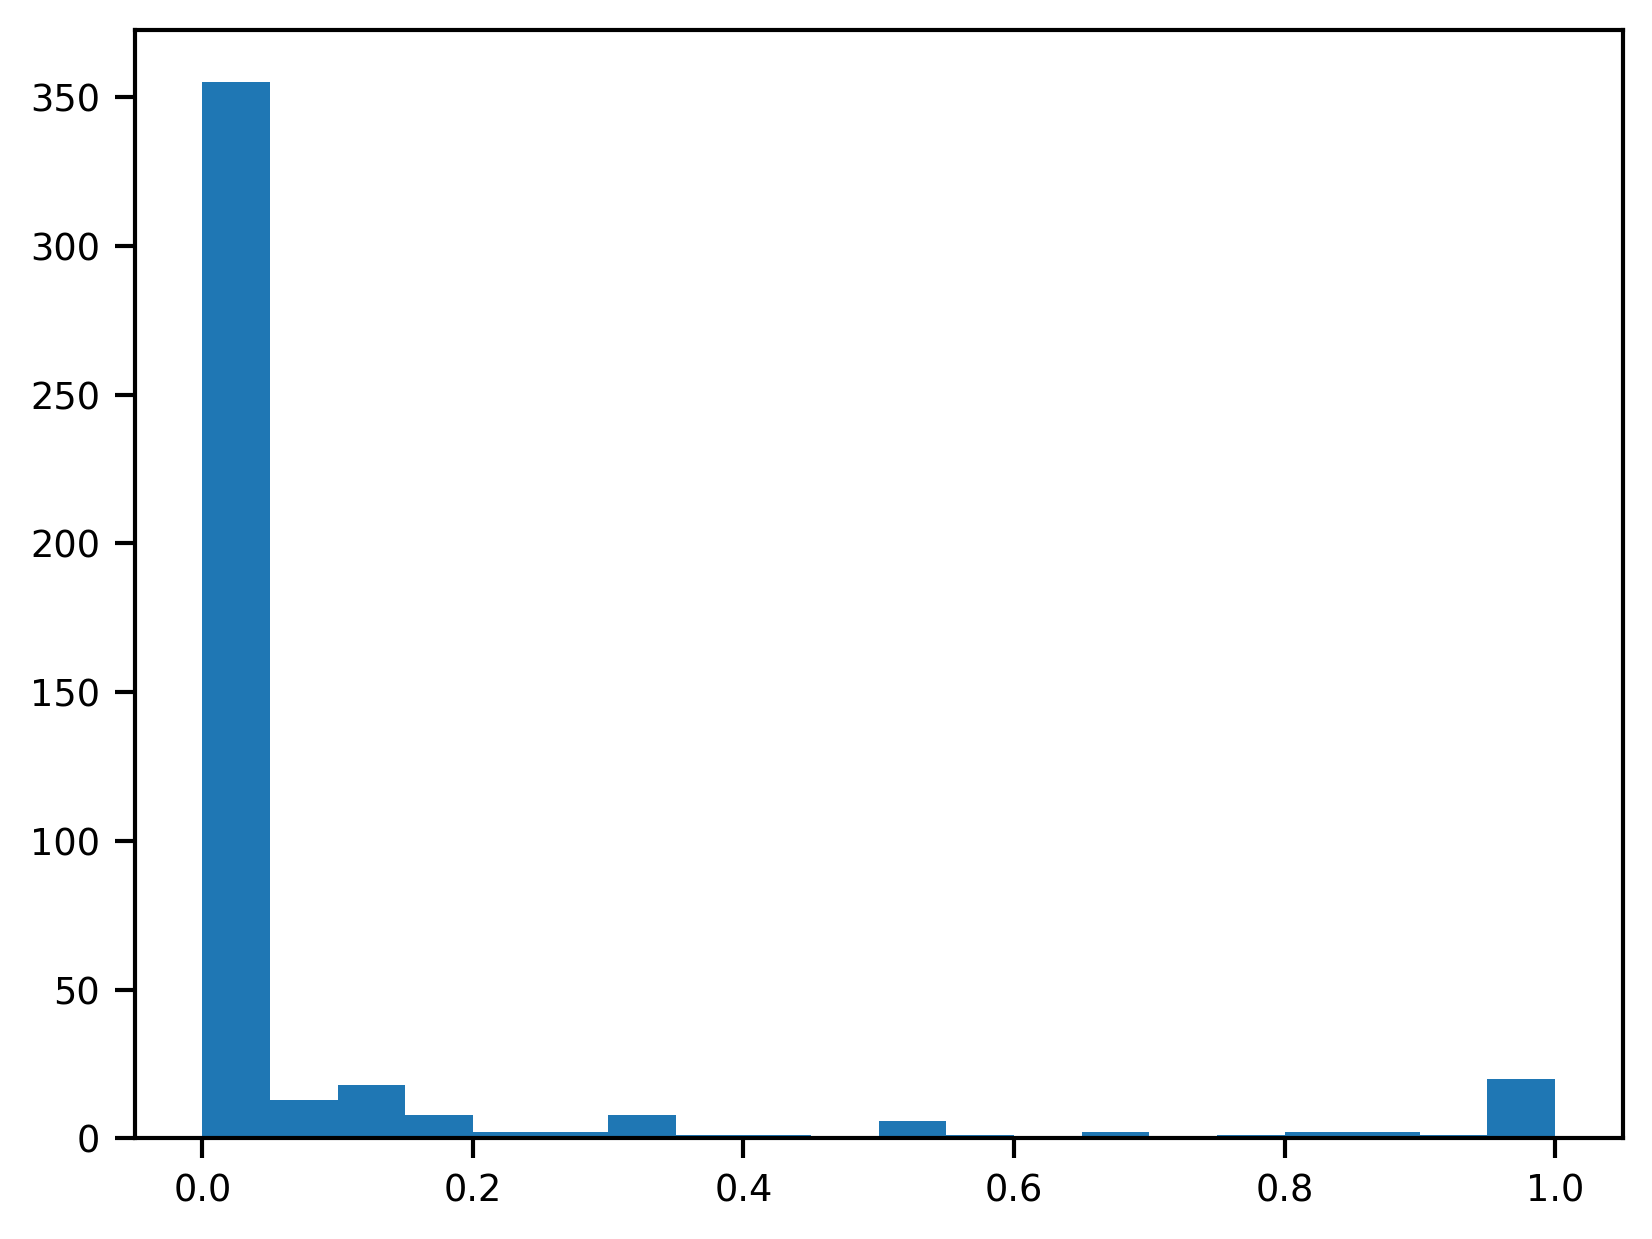

In [43]:
d1 = (
    d0.assign(has_amr_accessions=lambda x: x.num_amr_accessions.gt(0)).groupby("species")
    .has_amr_accessions.agg(['sum', 'mean', 'count'])
    .rename(columns={'sum': 'num_strains_with_amr', 'mean': 'frac_strains_with_amr', 'count': 'total_num_strains'})
    # .to_frame("frac_strains_with_amr")
    .join(species_taxonomy)
)
d1
plt.hist(d1.frac_strains_with_amr, bins=20)

/pollard/data/projects/bsmith/strain-corr/lib/plot.py:502: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


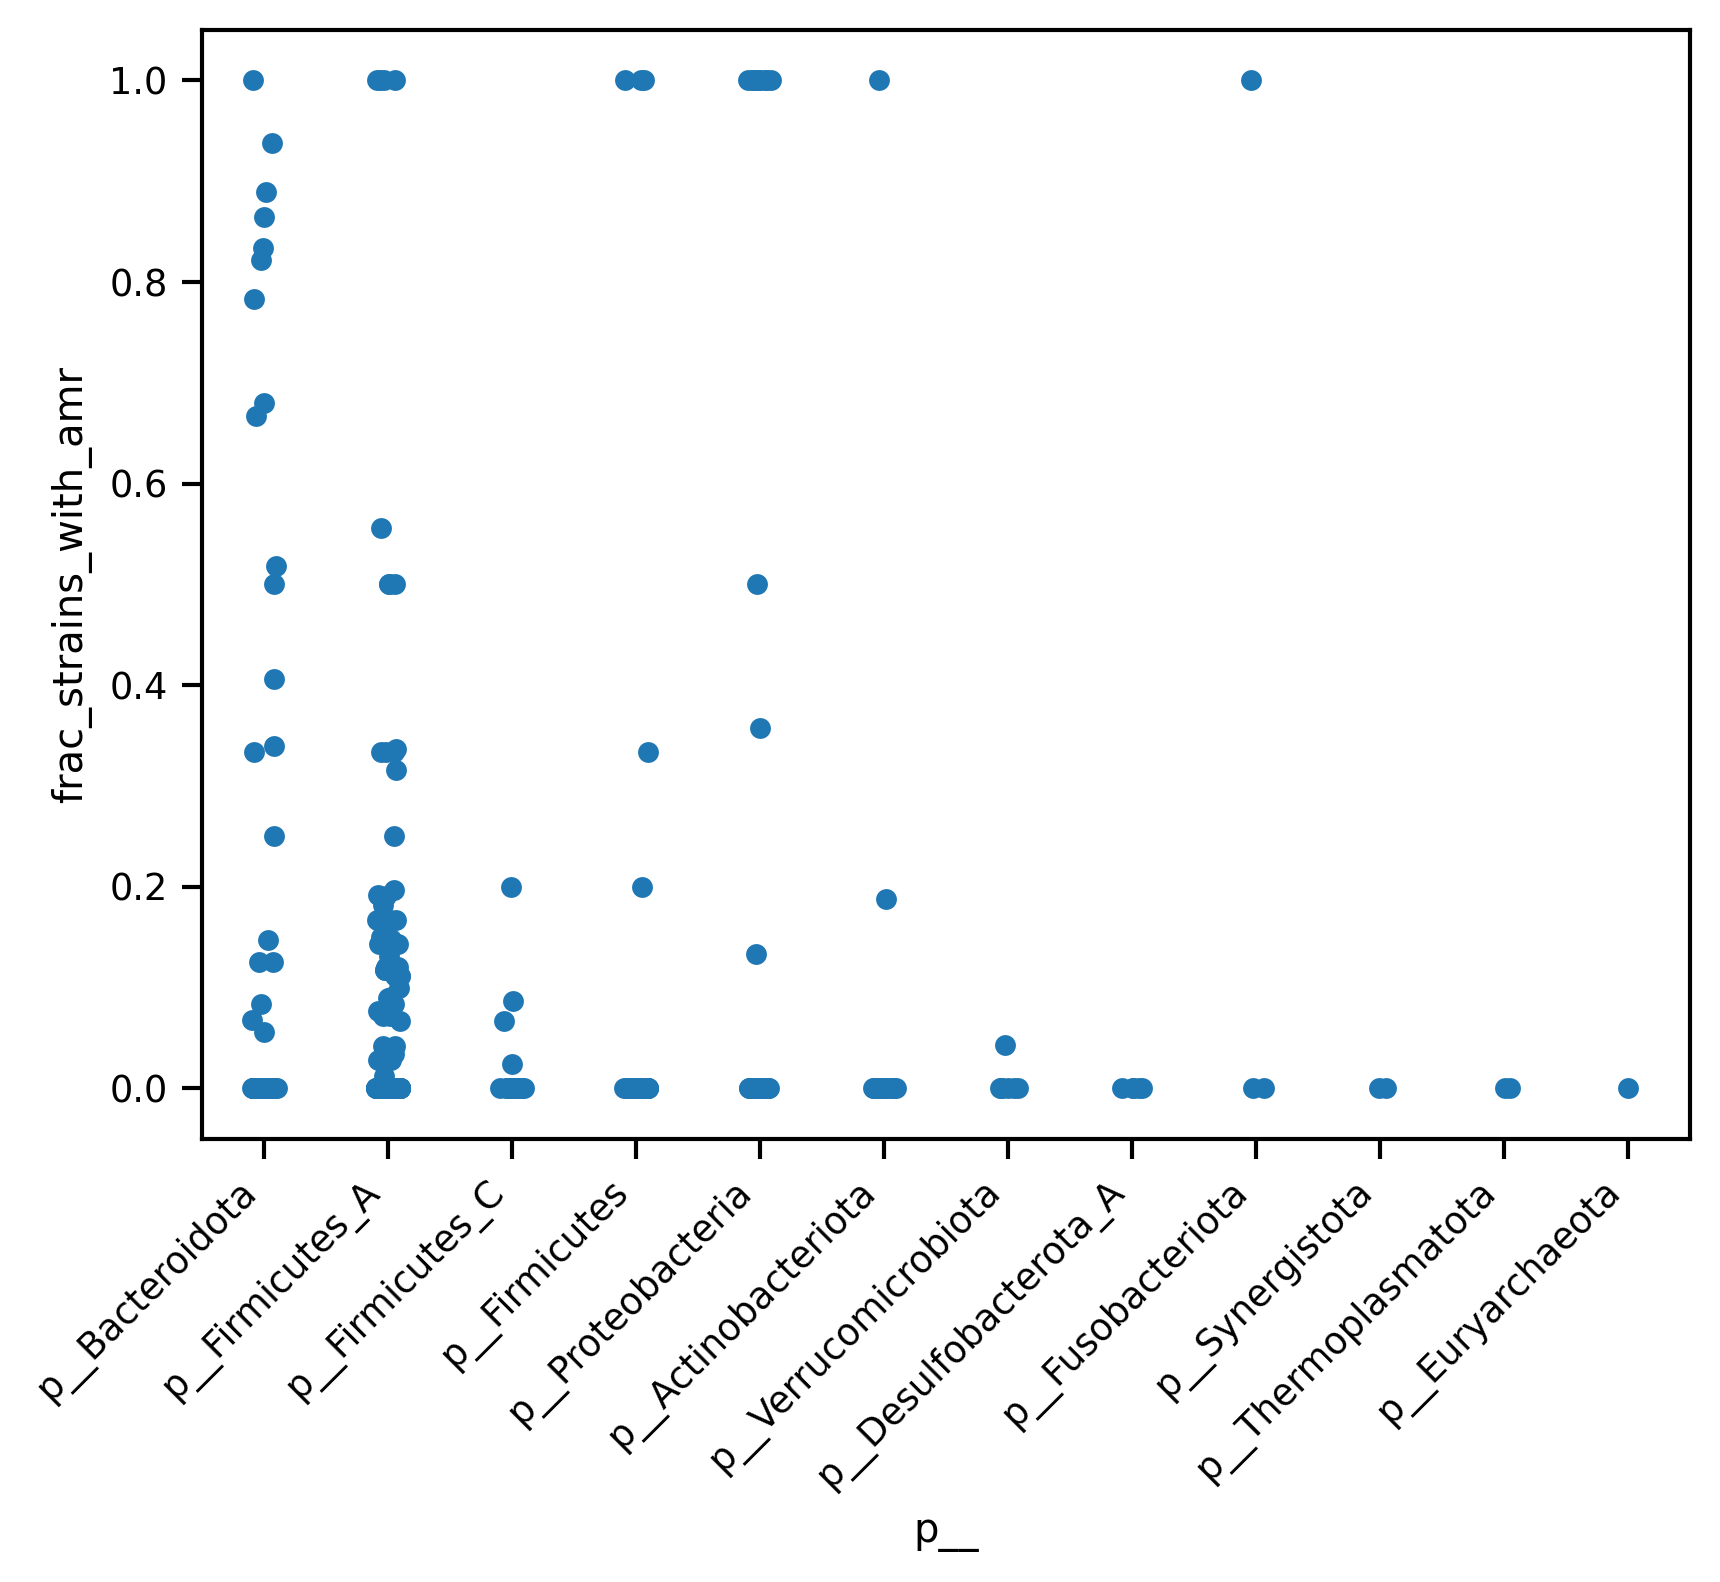

In [44]:
sns.stripplot(data=d1, x="p__", y="frac_strains_with_amr")
lib.plot.rotate_xticklabels()

In [45]:
is_amr_gene = []
for species in tqdm(species_list3):
    amr_annot_inpath = (
        f"data/species/sp-{species}/midasdb_v20.gene75_x_amr.tsv"
    )
    is_amr_gene.append(pd.read_table(amr_annot_inpath))

amr_gene_list = list(pd.concat(is_amr_gene).centroid_75.unique())#.drop_duplicates(subset='centroid_75').assign(is_amr_gene=True).set_index('centroid_75').is_amr_gene

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:02<00:00, 36.45it/s]


In [47]:
d0 = spgc_prevalence_class[lambda x: x != 'absent'].to_frame().assign(is_amr_gene=lambda x: x.index.to_series().isin(amr_gene_list))

for prevalence_class in ['core', 'shell', 'cloud', 'absent']:
    d1 = d0.assign(is_prevalence_class=lambda x: x.prevalence == prevalence_class)[['is_amr_gene', 'is_prevalence_class']].value_counts().unstack('is_prevalence_class').reindex(index=[False, True], columns=[False, True]).fillna(0)
    d1_pc = d1 + 1
    log_odds_ratio = np.log2((d1_pc.loc[True, True] / d1_pc.loc[True, False]) / (d1_pc.loc[False, True] / d1_pc.loc[False, False]))
    print(prevalence_class, log_odds_ratio, sp.stats.fisher_exact(d1))
    print(d1)


core -5.935371696774799 SignificanceResult(statistic=0.0, pvalue=1.5794374001895354e-23)
is_prevalence_class     False     True 
is_amr_gene                            
False                703762.0  214266.0
True                    200.0       0.0
shell -0.6916310896468305 SignificanceResult(statistic=0.603966858543042, pvalue=0.007829707078490377)
is_prevalence_class   False   True 
is_amr_gene                        
False                697921  220107
True                    168      32
cloud 2.2014417719555306 SignificanceResult(statistic=4.715051534668307, pvalue=1.8820857138492316e-20)
is_prevalence_class   False   True 
is_amr_gene                        
False                434373  483655
True                     32     168
absent 12.157128511510646 SignificanceResult(statistic=nan, pvalue=1.0)
is_prevalence_class   False  True 
is_amr_gene                       
False                918028    0.0
True                    200    0.0


In [48]:
d0.is_amr_gene.sum()

200

In [50]:
d0

,prevalence,is_amr_gene
gene_id,,
GUT_GENOME000007_00023,core,False
GUT_GENOME000007_00049,core,False
GUT_GENOME000007_00089,shell,False
GUT_GENOME000007_00119,core,False
GUT_GENOME000007_00122,shell,False
...,...,...
GUT_GENOME289259_04640,cloud,False
GUT_GENOME289259_04645,cloud,False
GUT_GENOME289260_03493,cloud,False


In [53]:
d0[lambda x: (x.prevalence == 'absent')]

,prevalence,is_amr_gene
gene_id,,
